In [7]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
import time
import pandas as pd
from datetime import date
from Ps_library_temp import *
from Hamiltonian_library import *
from config import *
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)

# Ideal desymmetrization

In [39]:
system = Ps_system(N_points=100)
sequence = laser_sequence()
rabi0 = 2*np.pi*(600e-3)
chirp = 2*np.pi*(3600e-3)
detuning = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 1
system.flag_SE_distributive = True
system.flag_photoionisation = True

#opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
#N = opt_red.tlist.size
#red_detuning = opt_red.optimized_controls[0]
#red_envelope = opt_red.optimized_controls[2]
#red_tlist = opt_red.tlist
#desymmetrization_kwargs = {
#    "envelope":red_envelope,
#    "detuning": red_detuning,
#    "tlist":red_tlist,
#   "unit_wavevector":direction
#    }
cooling_kwargs = {               
    "scale":100,
    "rabi0" : rabi0,
    "pulse_duration" : pulse_duration,
    "start":0,
    "end":int(3*pulse_duration)
    }
no_laser_kwargs = {
    "scale":100,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":1,
    "isSE" : True
    } 

#system.init_distribution_flattop()
system.init_distribution_MB()

N_pulses_in_train = 5
N_trains = 1
for j in range(N_trains):
    #desymmetrization_kwargs["label"] = "desymmetrization" +str(j)
    #sequence.init_pulse(desymmetrization_kwargs)
    
    for i in range(N_pulses_in_train):
        cooling_kwargs["label"]="cooling"+str(i+N_pulses_in_train*j)
        cooling_kwargs["unit_wavevector"] = (-1)**i*direction
        cooling_kwargs["detuning0"] = (-1)**i*detuning
        cooling_kwargs["chirp"] = (-1)**i*chirp
        sequence.init_pulse(cooling_kwargs)

    no_laser_kwargs["label"] = "no_laser"+str(j)
    sequence.init_pulse(no_laser_kwargs)


201
[8.97149497806281e-05, 9.898604456507014e-05, 0.00010910731909138448, 0.00012014468451305775, 0.00013216790324145384, 0.00014525068909947898, 0.00015947079707328678, 0.00017491010106377735, 0.00019165465796763397, 0.0002097947563523716, 0.0002294249479325301, 0.0002506440600061527, 0.000273555186973255, 0.000298265659032589, 0.00032488698614093614, 0.00035353477532177664, 0.00038432861942885063, 0.00041739195550607544, 0.0004528518909397852, 0.0004908389956733895, 0.0005314870588494292, 0.0005749328083604389, 0.0006213155919288966, 0.0006707770184983498, 0.0007234605589030386, 0.0007795111049921931, 0.0008390744866175901, 0.0009022969461487833, 0.0009693245704589938, 0.0010403026806253346, 0.0011153751799086336, 0.0011946838609193271, 0.0012783676732350245, 0.0013665619531103288, 0.0014593976173082439, 0.0015570003234820827, 0.0016594895999447437, 0.0017669779480749038, 0.0018795699210240433, 0.0019973611828002463, 0.0021204375522107448, 0.002248874036540864, 0.002382733860228225, 

In [40]:
handler = data_handler()
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
saved_states = []
results = []
stds = []
expect_ph = []
directory = "./data/test/"
for laser in sorted_sequence:
    laser = laser[1]
    print("Simulating {} ....".format(laser.label))
    if laser.isSE == True:
        SE_rate = 1 # 1ps corresponds to 3ns in this time-window
    else:
        SE_rate = None
    system.create_composite(laser,SE_rate)
    if laser.order == 0:
        system.init_states_desymmetrized() # ideally desymmetrized
        states = system.states
        std = handler.expect_standard_deviation(states,system.N_points)
        stds.append(std)
        #saved_states.append(states)
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1]
    
    #std = handler.expect_standard_deviation(states,system.N_points)
    #stds.append(std)

    #selector = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[0,0,0],[0,0,0],[0,0,1]]))
    #expect_ph.append((states*selector).tr())
    #print("std: {}".format(std))
    
    #results.append(result)
    #saved_states.append(states)

    filename = "{}_{}.csv".format(laser.order,laser.label)
    path = directory+filename
    qt.qsave(result,path)
print("Done!")

Simulating cooling0 ....
Simulating cooling1 ....
Simulating cooling2 ....
Simulating cooling3 ....
Simulating cooling4 ....
Simulating no_laser0 ....
Done!


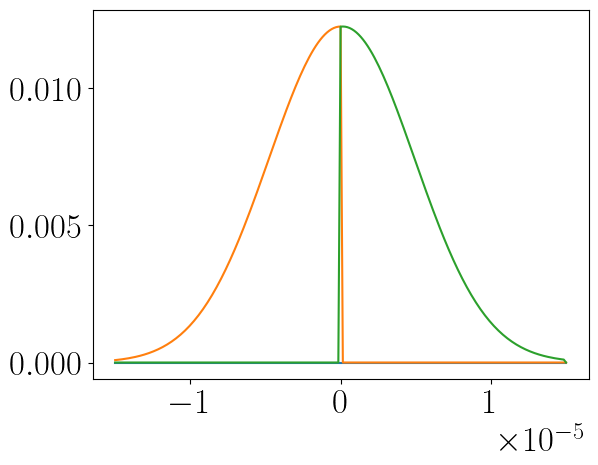

In [44]:
directory = "./data/test/"
files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
file = files_sorted[1]
path = directory+file
result = qt.qload(path)
#print(result.times)
system.organise_result(result)


for key in system.expect:
    plt.plot(system.velocity_bins,system.expect[key][0])

After 24 pulses,std: 19.28728663949495


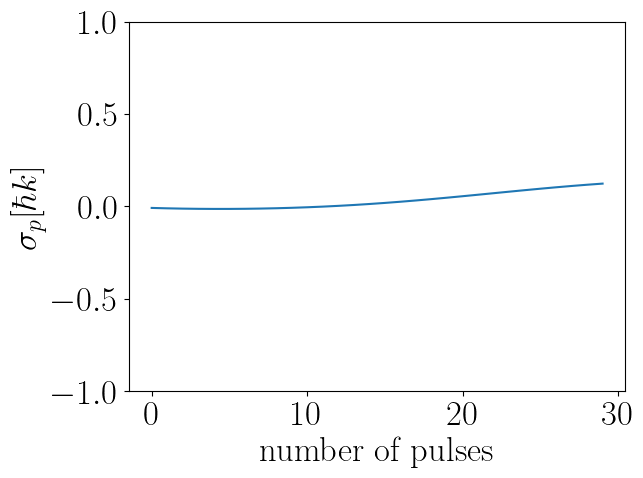

In [86]:
directory = "./data/ideal_desym_1ps_noSE/"
files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
stds = []
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    
    std = handler.expect_standard_deviation(result.states[-1],system.N_points)
    stds.append(std)
    #system.organise_result(result)
    # fig,ax = plt.subplots()
    # for key in system.expect:
    #     #if key == "ph.":
    #     ax.plot(system.velocity_bins,system.expect[key][-1],label=key)
    # plt.legend()
    # plt.show()

pulses_arr = np.arange(len(stds))

#expected_std = np.sqrt(stds[0]**2 - (4*pulses_arr+1)*stds[0]/np.sqrt(2*np.pi) + pulses_arr**2 + 0.5)
#expected_std = np.sqrt(stds[0]**2 - (4*pulses_arr+1)*stds[0]/np.sqrt(2*np.pi) + pulses_arr**2 + 0.7+ pulses_arr)
#expected_std = np.sqrt(stds[1]**2 - pulses_arr*(4*stds[1]/np.sqrt(2*np.pi)+1) + 2*stds[1]/(np.sqrt(2*np.pi)) + pulses_arr**2 + 0.5)
N_m = 24
N_ms = 0.5
expected_std = np.sqrt(stds[0]**2 + pulses_arr**2-2*pulses_arr*N_m + N_ms)
#plt.plot(np.arange(len(stds)),stds,label="simulation")
#plt.plot(np.arange(len(stds)),expected_std,label="simulation")
plt.plot(pulses_arr,stds - expected_std,label="expected")
#plt.legend()
#plt.plot(np.argmin(stds),np.amin(stds),'o',color="orange")
plt.xlabel("number of pulses")
plt.ylabel(r"$\sigma_p [\hbar k]$")
plt.ylim(-1,1)
#plt.savefig("./figures/thesis/ideal_std_evolution_diff.svg",bbox_inches="tight")
print("After {:.0f} pulses,std: {}".format(np.argmin(stds),np.amin(stds)))

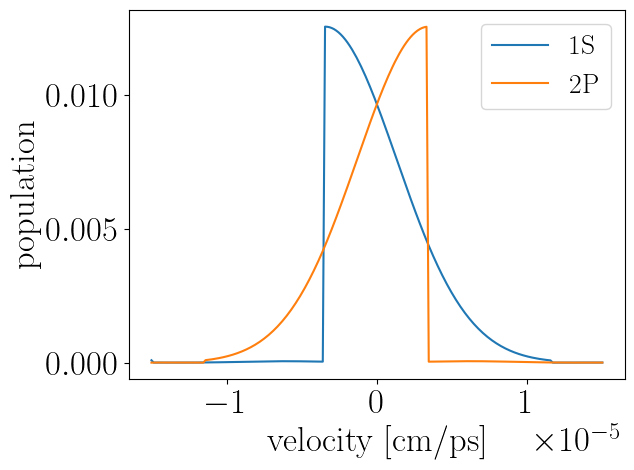

In [ ]:

system.organise_result(results[22])
fig,ax = plt.subplots()
#ax.plot(system.velocity_bins,system.expect["1S"][0]+system.expect["2P"][0],label="initial",color="black",linewidth=1)
ax.plot(system.velocity_bins,system.expect["1S"][-1],label="1S")
ax.plot(system.velocity_bins,system.expect["2P"][-1],label="2P")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("population")
#for key in system.expect:
    #if key == "ph.":
    #ax.plot(system.velocity_bins,system.expect[key][-1],label=key)
plt.legend(fontsize=20)
#plt.savefig("./figures/thesis/ideal_desymmetrization_coldest_state.svg",bbox_inches="tight")
plt.show()


# Ideal desymmetrization, and with SE and photoionisation

In [2]:
system = Ps_system(N_points=100)
sequence = laser_sequence()
rabi0 = 2*np.pi*(150e-3)
chirp = 2*np.pi*(250e-3)
detuning = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 10
system.flag_SE_distributive = True
system.flag_photoionisation = True

opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
N = opt_red.tlist.size
red_detuning = opt_red.optimized_controls[0]
red_envelope = opt_red.optimized_controls[2]
red_tlist = opt_red.tlist
desymmetrization_kwargs = {
    "envelope":red_envelope,
    "detuning": red_detuning,
    "tlist":red_tlist,
    "unit_wavevector":direction
    }
cooling_kwargs = {               
    "scale":1000,
    "rabi0" : rabi0,
    "pulse_duration" : pulse_duration,
    "start":0,
    "end":int(3*pulse_duration)
    }
no_laser_kwargs = {
    "scale":1000,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":4,
    "isSE" : True
    } 

#system.init_distribution_flattop()
system.init_distribution_MB()

N_pulses_in_train = 30
N_trains = 1
for j in range(N_trains):
    #desymmetrization_kwargs["label"] = "desymmetrization" +str(j)
    #sequence.init_pulse(desymmetrization_kwargs)
    
    for i in range(N_pulses_in_train):
        cooling_kwargs["label"]="cooling"+str(i+N_pulses_in_train*j)
        cooling_kwargs["unit_wavevector"] = (-1)**i*direction
        cooling_kwargs["detuning0"] = (-1)**i*detuning
        cooling_kwargs["chirp"] = (-1)**i*chirp
        sequence.init_pulse(cooling_kwargs)

    no_laser_kwargs["label"] = "no_laser"+str(j)
    sequence.init_pulse(no_laser_kwargs)


4.771275352895774e-06


In [3]:
handler = data_handler()
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
saved_states = []
results = []
stds = []
expect_ph = []
directory = "./data/cooling_with_ideal_desymmetrization_with_dissipation_10ps/"
for laser in sorted_sequence:
    laser = laser[1]
    print("Simulating {} ....".format(laser.label))
    if laser.isSE == True:
        SE_rate = 1 # 1ps corresponds to 3ns in this time-window
    else:
        SE_rate = None
    system.create_composite(laser,SE_rate)
    if laser.order == 0:
        system.init_states_desymmetrized()
        states = system.states
        std = handler.expect_standard_deviation(states,system.N_points)
        stds.append(std)
        #saved_states.append(states)
    
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1]
    
    std = handler.expect_standard_deviation(states,system.N_points)
    stds.append(std)

    selector = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[0,0,0],[0,0,0],[0,0,1]]))
    expect_ph.append((states*selector).tr())
    #print("std: {}".format(std))
    
    results.append(result)
    #saved_states.append(states)
    filename = "{}_{}.csv".format(laser.order,laser.label)
    path = directory+filename
    qt.qsave(result,path)
print("Done!")

Simulating cooling0 ....
Simulating cooling1 ....
Simulating cooling2 ....
Simulating cooling3 ....
Simulating cooling4 ....
Simulating cooling5 ....
Simulating cooling6 ....
Simulating cooling7 ....
Simulating cooling8 ....
Simulating cooling9 ....
Simulating cooling10 ....
Simulating cooling11 ....
Simulating cooling12 ....
Simulating cooling13 ....
Simulating cooling14 ....
Simulating cooling15 ....
Simulating cooling16 ....
Simulating cooling17 ....
Simulating cooling18 ....
Simulating cooling19 ....
Simulating cooling20 ....
Simulating cooling21 ....
Simulating cooling22 ....
Simulating cooling23 ....
Simulating cooling24 ....
Simulating cooling25 ....
Simulating cooling26 ....
Simulating cooling27 ....
Simulating cooling28 ....
Simulating cooling29 ....
Simulating no_laser0 ....
Done!


In [ ]:
directory = "./data/c"
files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
stds = []
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    system.organise_result(result)
    fig,ax = plt.subplots()
    for key in system.expect:
        #if key == "ph.":
        ax.plot(system.velocity_bins,system.expect[key][-1],label=key)
    plt.legend()
    plt.show()

After 26 pulses,std: 20.168699396135207


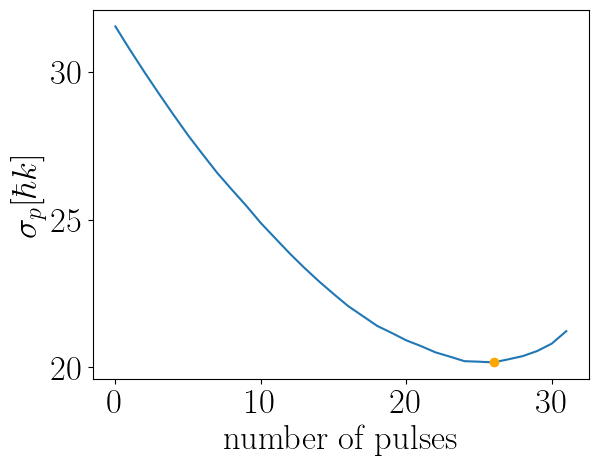

In [5]:
pulses_arr = np.arange(len(stds))

#expected_std = np.sqrt(stds[0]**2 - (4*pulses_arr+1)*stds[0]/np.sqrt(2*np.pi) + pulses_arr**2 + 0.5)
#expected_std = np.sqrt(stds[0]**2 - (4*pulses_arr)*stds[0]/np.sqrt(2*np.pi) + pulses_arr**2 + 0.5+ pulses_arr)
#expected_std = np.sqrt(stds[1]**2 - pulses_arr*(4*stds[1]/np.sqrt(2*np.pi)+1) + 2*stds[1]/(np.sqrt(2*np.pi)) + pulses_arr**2 + 0.5)

plt.plot(np.arange(len(stds)),stds,label="simulation")
#plt.plot(pulses_arr,stds - expected_std,label="expected")
#plt.legend()
plt.plot(np.argmin(stds),np.amin(stds),'o',color="orange")
plt.xlabel("number of pulses")
plt.ylabel(r"$\sigma_p [\hbar k]$")
#plt.ylim(-1,1)
print("After {:.0f} pulses,std: {}".format(np.argmin(stds),np.amin(stds)))
plt.savefig("./figures/thesis/std_evolution_dissipation_10ps.svg")

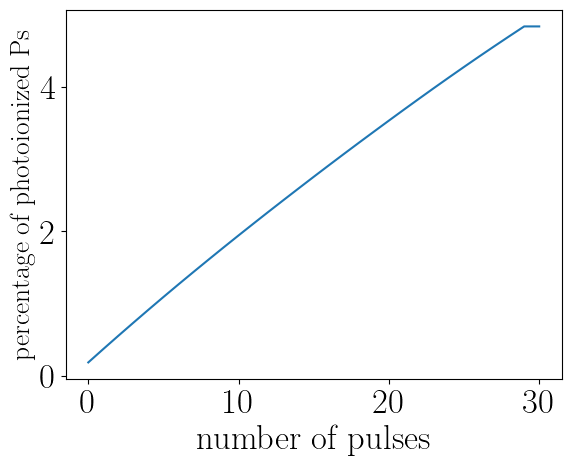

In [7]:
plt.plot(np.arange(len(stds)-1), np.asarray(expect_ph)*100)
plt.ylabel("percentage of photoionized Ps",fontsize=20)
plt.xlabel("number of pulses")
plt.savefig("./figures/thesis/photoionization_cooling_10ps.svg")

In [ ]:

system.organise_result(results[0])
fig,ax = plt.subplots()
#ax.plot(system.velocity_bins,system.expect["1S"][0]+system.expect["2P"][0],label="initial",color="black",linewidth=1)
ax.plot(system.velocity_bins,system.expect["1S"][0],label="1S")
ax.plot(system.velocity_bins,system.expect["2P"][0],label="2P")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("population")
#for key in system.expect:
    #if key == "ph.":
    #ax.plot(system.velocity_bins,system.expect[key][-1],label=key)
plt.legend(fontsize=20)
#plt.savefig("./figures/thesis/ideal_desymmetrization_with_dissipation_initial_state.svg",bbox_inches="tight")
plt.show()


# Ideal desymmetrization, cooling with multiple trains

In [21]:
system = Ps_system(N_points=100)
sequence = laser_sequence()
rabi0 = 2*np.pi*(600e-3)
chirp = 2*np.pi*(2500e-3)
detuning = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 1
system.flag_SE_distributive = True
system.flag_photoionisation = True

opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
N = opt_red.tlist.size
red_detuning = opt_red.optimized_controls[0]
red_envelope = opt_red.optimized_controls[2]
red_tlist = opt_red.tlist
desymmetrization_kwargs = {
    "envelope":red_envelope,
    "detuning": red_detuning,
    "tlist":red_tlist,
    "unit_wavevector":direction
    }
cooling_kwargs = {               
    "scale":1000,
    "rabi0" : rabi0,
    "pulse_duration" : pulse_duration,
    "start":0,
    "end":int(3*pulse_duration)
    }
no_laser_kwargs = {
    "scale":100,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":1,
    "isSE" : True
    } 

#system.init_distribution_flattop()
system.init_distribution_MB()

# ideal number of pulses per train were chosen based on simulations
#N_pulses_in_train = [25,18,12,7] # try 1
N_pulses_in_train = [25,16,9,6] # try 2 Works!
#N_pulses_in_train = [2,2]

N_trains = 4
k=0
for j in range(N_trains):
    desymmetrization_kwargs["label"] = "desymmetrization-" +str(j)
    sequence.init_pulse(desymmetrization_kwargs)
    
    for i in range(N_pulses_in_train[j]):
        cooling_kwargs["label"]="cooling"+str(k)
        cooling_kwargs["unit_wavevector"] = (-1)**i*direction
        cooling_kwargs["detuning0"] = (-1)**i*detuning
        cooling_kwargs["chirp"] = (-1)**i*chirp
        sequence.init_pulse(cooling_kwargs)
        k+=1

    no_laser_kwargs["label"] = "no_laser"+str(j)
    sequence.init_pulse(no_laser_kwargs)
start=True

4.771275352895774e-06


In [22]:
handler = data_handler()
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
saved_states = []
results = []
stds = []
expect_ph = []
directory = "./data/ideal_desym_1ps_1SE_event/"
for laser in sorted_sequence:
    laser = laser[1]
    print("Simulating {} ....".format(laser.label))
    if laser.isSE == True:
        SE_rate = 1 # 1ps corresponds to 3ns in this time-window
    else:
        SE_rate = None
    system.create_composite(laser,SE_rate)
    if laser.order == 0:
        system.init_states_desymmetrized()
        states = system.states
        std = handler.expect_standard_deviation(states,system.N_points)
        stds.append(std)
        #saved_states.append(states)
    if laser.label.split('-')[0] == "desymmetrization":
        desymmetrizer_qobj = qt.tensor(qt.qdiags(np.where(system.momentum_bins > 0,1,0),offsets=0),qt.Qobj([[0,0,0],[1,1,0],[0,0,1]]))
        #desymmetrizer_qobj = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[1,0,0],[1,1,0],[0,0,1]]))
        keep_state_qobj = qt.tensor(qt.qdiags(np.where(system.momentum_bins <=0,1,0),offsets=0),qt.Qobj([[1,0,0],[0,1,0],[0,0,1]]))
        states = (desymmetrizer_qobj*states.copy()*desymmetrizer_qobj.dag() + keep_state_qobj*states.copy()*keep_state_qobj.dag()).unit()
        #states = desymmetrizer_qobj*states.copy()
        std = handler.expect_standard_deviation(states,system.N_points)
        stds.append(std)
        continue
        
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1]
    
    std = handler.expect_standard_deviation(states,system.N_points)
    stds.append(std)

    selector = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[0,0,0],[0,0,0],[0,0,1]]))
    expect_ph.append((states.copy()*selector).tr())
    #print("std: {}".format(std))
    
    #results.append(result)
    #saved_states.append(states)
    filename = "{}_{}.csv".format(laser.order,laser.label)
    path = directory+filename
    qt.qsave(result,path)
print("Done!")

Simulating desymmetrization-0 ....
Simulating cooling0 ....
Simulating cooling1 ....
Simulating cooling2 ....
Simulating cooling3 ....
Simulating cooling4 ....
Simulating cooling5 ....
Simulating cooling6 ....
Simulating cooling7 ....
Simulating cooling8 ....
Simulating cooling9 ....
Simulating cooling10 ....
Simulating cooling11 ....
Simulating cooling12 ....
Simulating cooling13 ....
Simulating cooling14 ....
Simulating cooling15 ....
Simulating cooling16 ....
Simulating cooling17 ....
Simulating cooling18 ....
Simulating cooling19 ....
Simulating cooling20 ....
Simulating cooling21 ....
Simulating cooling22 ....
Simulating cooling23 ....
Simulating cooling24 ....
Simulating no_laser0 ....
Simulating desymmetrization-1 ....
Simulating cooling25 ....
Simulating cooling26 ....
Simulating cooling27 ....
Simulating cooling28 ....
Simulating cooling29 ....
Simulating cooling30 ....
Simulating cooling31 ....
Simulating cooling32 ....
Simulating cooling33 ....
Simulating cooling34 ....
Simu

AttributeError: 'Ps_system' object has no attribute 'idx_e_ops'

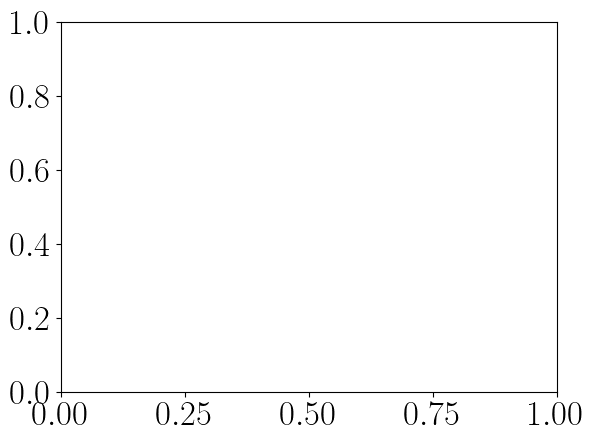

In [16]:
directory = "./data/ideal_desym_1ps_3SE_event/"


files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
fig,ax = plt.subplots()

file = files_sorted[0]
path = directory+file
result = qt.qload(path)
system.organise_result(result)
ax.plot(system.velocity_bins,system.expect["1S"][0]+system.expect["2P"][0],color="black",label="initial")

file = files_sorted[-1]
path = directory+file
result = qt.qload(path)
system.organise_result(result)
ax.plot(system.velocity_bins,system.expect["1S"][-1],label="final")

plt.ylabel("Population")
plt.xlabel("velocity [cm/ps]")


plt.legend()
#plt.savefig("./figures/thesis/doppler_final_state_1ps.svg")
plt.show()

TypeError: Invalid shape (0,) for image data

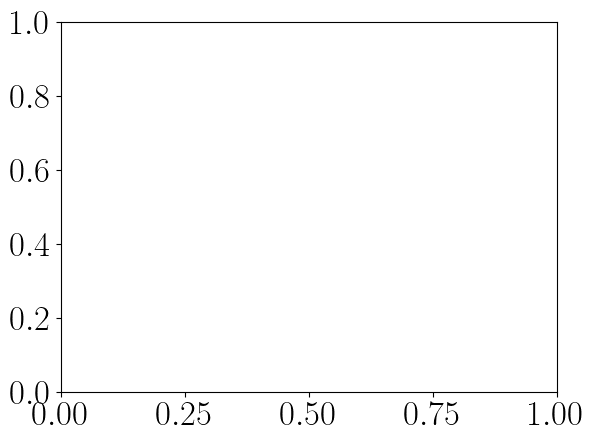

In [17]:
directory = "./data/ideal_desym_1ps_4SE_event/"


files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
fig,ax = plt.subplots()

array = []
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    system.organise_result(result)
    
    new_arr = system.expect["1S"][-1]+system.expect["2P"][-1]#+system.expect["ph."][-1]
    array.append(new_arr)

plt.imshow(np.asarray(array).T,aspect="auto",origin="lower")
ticks = [0,50,100,150,200]
plt.yticks(ticks, ["{:.1e}".format(system.velocity_bins[tick]) for tick in ticks])
plt.colorbar()
plt.ylabel("velocity [cm/ps]")
plt.xlabel("number of pulses")
#plt.savefig("./figures/thesis/doppler_evolution_1ps.svg")
plt.show()

31.516278006823484
After 63 pulses,std: 10.880424769453157


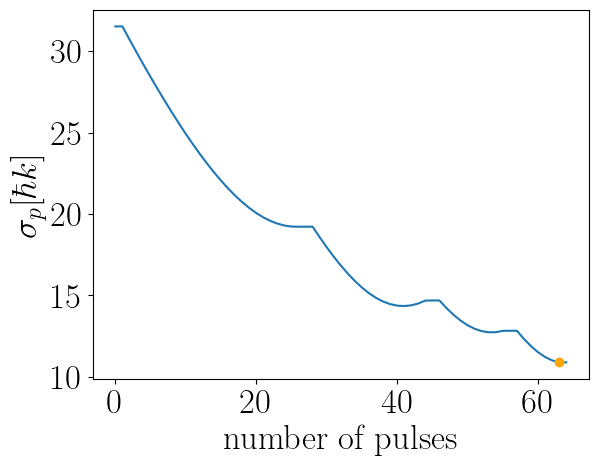

In [24]:
pulses_arr = np.arange(len(stds))
print(stds[0])
#expected_std = np.sqrt(stds[0]**2 - (4*pulses_arr+1)*stds[0]/np.sqrt(2*np.pi) + pulses_arr**2 + 0.5)
#expected_std = np.sqrt(stds[0]**2 - (4*pulses_arr)*stds[0]/np.sqrt(2*np.pi) + pulses_arr**2 + 0.5+ pulses_arr)
#expected_std = np.sqrt(stds[1]**2 - pulses_arr*(4*stds[1]/np.sqrt(2*np.pi)+1) + 2*stds[1]/(np.sqrt(2*np.pi)) + pulses_arr**2 + 0.5)

plt.plot(np.arange(len(stds)),stds,label="simulation")
#plt.plot(pulses_arr,stds - expected_std,label="expected")
#plt.legend()
plt.plot(np.argmin(stds),np.amin(stds),'o',color="orange")
plt.xlabel("number of pulses")
plt.ylabel(r"$\sigma_p [\hbar k]$")
#plt.ylim(-1,1)
print("After {:.0f} pulses,std: {}".format(np.argmin(stds),np.amin(stds)))
plt.savefig("./figures/paper/multi_train_1ps_1SE.svg")

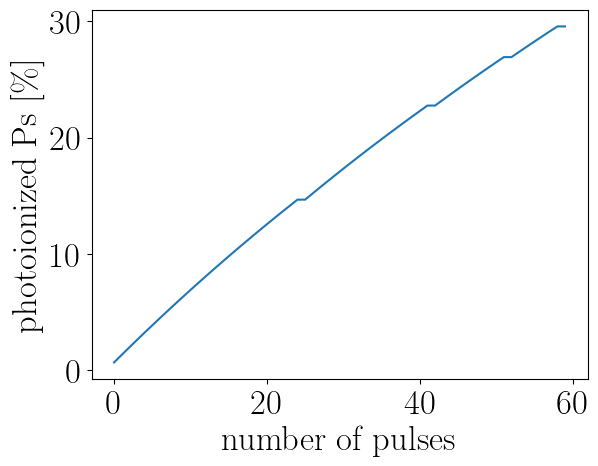

In [153]:
directory = "./data/cooling_with_ideal_desymmetrization_trains_1ps/"


files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
fig,ax = plt.subplots()

ph_arr = []
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    system.organise_result(result)
    
    ph_arr.append(np.sum(system.expect["ph."][-1])*100)
    
plt.plot(np.arange(len(ph_arr)),ph_arr)
plt.ylabel(r"photoionized Ps $[\%]$")
plt.xlabel("number of pulses")
plt.savefig("./figures/thesis/doppler_evolution_photoionisation_1ps.svg")
plt.show()

# cooling with krotov

In [ ]:
system = Ps_system(N_points=100)
sequence = laser_sequence()
rabi0 = 2*np.pi*(1000e-3)
chirp = 2*np.pi*(3000e-3)
detuning = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 1
#system.flag_SE_distributive = True
#system.flag_photoionisation = True

opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
N = opt_red.tlist.size
red_detuning = opt_red.optimized_controls[0]
red_envelope = opt_red.optimized_controls[2]
red_tlist = opt_red.tlist
desymmetrization_kwargs = {
    "envelope":red_envelope,
    "detuning": red_detuning,
    "tlist":red_tlist,
    "unit_wavevector":direction
    }
cooling_kwargs = {               
    "scale":1000,
    "rabi0" : rabi0,
    "pulse_duration" : pulse_duration,
    "start":0,
    "end":int(3*pulse_duration)
    }
no_laser_kwargs = {
    "scale":1000,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":4,
    "isSE" : True
    } 

#system.init_distribution_flattop()
system.init_distribution_MB()

N_pulses_in_train = 30
N_trains = 1
for j in range(N_trains):
    desymmetrization_kwargs["label"] = "desymmetrization" +str(j)
    sequence.init_pulse(desymmetrization_kwargs)
    
    for i in range(N_pulses_in_train):
        cooling_kwargs["label"]="cooling"+str(i+N_pulses_in_train*j)
        cooling_kwargs["unit_wavevector"] = (-1)**i*direction
        cooling_kwargs["detuning0"] = (-1)**i*detuning
        cooling_kwargs["chirp"] = (-1)**i*chirp
        sequence.init_pulse(cooling_kwargs)

    #no_laser_kwargs["label"] = "no_laser"+str(j)
    #sequence.init_pulse(no_laser_kwargs)


4.771275352895774e-06


In [ ]:
handler = data_handler()
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
saved_states = []
results = []
stds = []
expect_ph = []
for laser in sorted_sequence:
    laser = laser[1]
    print("Simulating {} ....".format(laser.label))
    if laser.isSE == True:
        SE_rate = 1 # 1ps corresponds to 3ns in this time-window
    else:
        SE_rate = None
    system.create_composite(laser,SE_rate)
    if laser.order == 0:
        system.init_states_ground() # important to have ground state initiating after creating internal state space...
        states = system.states
        #saved_states.append(states)
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1]
    
    std = handler.expect_standard_deviation(states,system.N_points)
    stds.append(std)

    #selector = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[0,0,0],[0,0,0],[0,0,1]]))
    #expect_ph.append((states*selector).tr())
    #print("std: {}".format(std))
    
    #results.append(result)
    #saved_states.append(states)
print("Done!")

Simulating desymmetrization0 ....
Simulating cooling0 ....
Simulating cooling1 ....
Simulating cooling2 ....
Simulating cooling3 ....
Simulating cooling4 ....
Simulating cooling5 ....
Simulating cooling6 ....
Simulating cooling7 ....
Simulating cooling8 ....
Simulating cooling9 ....
Simulating cooling10 ....
Simulating cooling11 ....
Simulating cooling12 ....
Simulating cooling13 ....
Simulating cooling14 ....
Simulating cooling15 ....
Simulating cooling16 ....
Simulating cooling17 ....
Simulating cooling18 ....
Simulating cooling19 ....
Simulating cooling20 ....
Simulating cooling21 ....
Simulating cooling22 ....
Simulating cooling23 ....
Simulating cooling24 ....
Simulating cooling25 ....
Simulating cooling26 ....
Simulating cooling27 ....
Simulating cooling28 ....
Simulating cooling29 ....
Done!


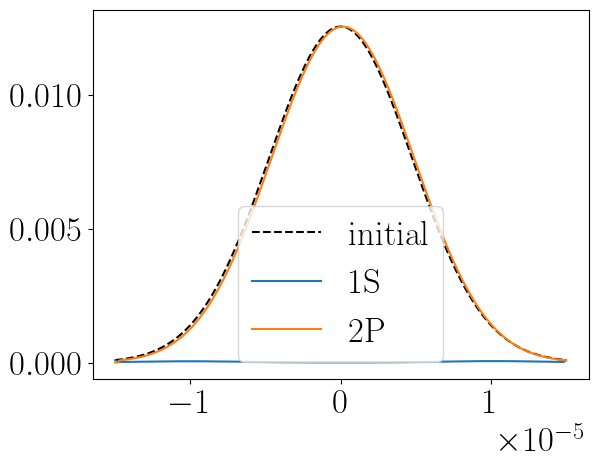

In [ ]:
for result in results:
    system.organise_result(result)
    fig,ax = plt.subplots()
    ax.plot(system.velocity_bins,system.expect["1S"][0],label="initial",ls="dashed",color="black")
    for key in system.expect:
        #if key == "ph.":
        ax.plot(system.velocity_bins,system.expect[key][-1],label=key)
    plt.legend()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (31,) and (0,)

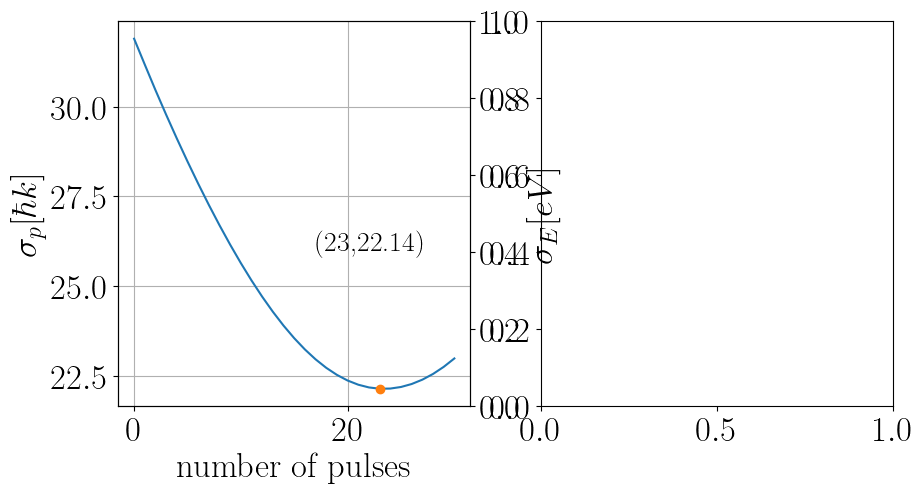

In [ ]:
handler = data_handler()
# stds = []
#ph_pops = []

# for state in saved_states:
#     #selector = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[0,0,0],[0,0,0],[0,0,1]]))
#     #ph_pops.append((state*selector).tr())
#     std = handler.expect_standard_deviation(state,system.N_points)
#     stds.append(std)
#     stds_E.append(std**2/(2*system.m/c**2))
    #stds.append(handler.expect_standard_deviation(state,system.N_points))
#stds_E = []
#for std in stds:
#    stds_E.append(std**2/(2*system.m/c**2))
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(np.arange(len(stds)),stds)

twinay = axes[0].twinx()
#twinay.plot(np.arange(len(stds)),stds_E,alpha=0)

axes[0].set_ylabel(r"$\sigma_p [\hbar k]$")
axes[0].set_xlabel("number of pulses")
twinay.set_ylabel(r"$\sigma_E [eV]$")
axes[0].plot(np.argmin(stds),np.amin(stds),'o')
axes[0].grid()
axes[0].text(17,26,"({:.0f},{:.2f})".format(np.argmin(stds),np.amin(stds)),fontsize=20)

axes[1].plot(np.arange(len(stds)),expect_ph)
axes[1].set_xlabel("number of pulses")
axes[1].set_ylabel("ratio, photoionized",fontsize=20)
fig.tight_layout()
#plt.title("4 Trains, 2 Pulses, 4 SE events")

#print("minimum: {:.2f} after {} pulses".format(np.amin(stds),np.argmin(stds)))
#plt.grid()
#plt.savefig("./figures/thesis_draft/broadband_20ps.svg",bbox_inches="tight")
#print(stds)

# Cooling with trains of ideal number of pulses (maximum cooling per train)

In [ ]:
system = Ps_system(N_points=100)
sequence = laser_sequence()
rabi0 = 2*np.pi*(100e-3)
chirp = 2*np.pi*(150e-3)
detuning = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 20
system.flag_SE_distributive = True
system.flag_photoionisation = True

opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
N = opt_red.tlist.size
red_detuning = opt_red.optimized_controls[0]
red_envelope = opt_red.optimized_controls[2]
red_tlist = opt_red.tlist
desymmetrization_kwargs = {
    "envelope":red_envelope,
    "detuning": red_detuning,
    "tlist":red_tlist,
    "unit_wavevector":direction
    }
cooling_kwargs = {               
    "scale":1000,
    "rabi0" : rabi0,
    "pulse_duration" : pulse_duration,
    "start":0,
    "end":int(3*pulse_duration)
    }
no_laser_kwargs = {
    "scale":1000,
    "rabi0" : 0,
    "detuning0": 0,
    "chirp" : 0,
    "pulse_duration" : pulse_duration,
    "unit_wavevector":direction,
    "start":0,
    "end":4,
    "isSE" : True
    } 

#system.init_distribution_flattop()
system.init_distribution_MB()

# ideal number of pulses per train were chosen based on simulations
#N_pulses_in_train = [26,16,12,11] # try 1
#N_pulses_in_train = [23,15,10,8] # try 2
N_pulses_in_train = [23,14,8,5] # try 3 Works!
#N_pulses_in_train = [30]
N_trains = 4
k=0
for j in range(N_trains):
    desymmetrization_kwargs["label"] = "desymmetrization" +str(j)
    sequence.init_pulse(desymmetrization_kwargs)
    
    for i in range(N_pulses_in_train[j]):
        cooling_kwargs["label"]="cooling"+str(k)
        cooling_kwargs["unit_wavevector"] = (-1)**i*direction
        cooling_kwargs["detuning0"] = (-1)**i*detuning
        cooling_kwargs["chirp"] = (-1)**i*chirp
        sequence.init_pulse(cooling_kwargs)
        k+=1

    no_laser_kwargs["label"] = "no_laser"+str(j)
    sequence.init_pulse(no_laser_kwargs)
start=True

4.771275352895774e-06


In [ ]:
# last_result = qt.qload("./data/cooling/ideal_4Trains_23_15_10_8_Pulses_4SE_15ps/61_cooling54.csv")
# states = last_result.states[-1]

# sorted_sequence = sequence.pull_sorted_sequence()
# new_sorted_sequence = []

# start_new_sequence = False
# for element in sorted_sequence:
#     if element[0] == "cooling54":
#         start_new_sequence = True
#         continue
#     if start_new_sequence:
#         new_sorted_sequence.append(element)

# sorted_sequence = new_sorted_sequence
# print(sorted_sequence)

[('cooling55', <Ps_library_temp.laser_new object at 0x7ff29317a500>), ('no_laser3', <Ps_library_temp.laser_new object at 0x7ff29317a3b0>)]


In [ ]:
handler = data_handler()
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
#saved_states = []
#results = []
stds2 = []
expect_ph = []
handler = data_handler()
directory = "./data/cooling/ideal_try3_20ps/"
for laser in sorted_sequence:
    laser = laser[1]
    print("Simulating {} ....".format(laser.label))
    if laser.isSE == True:
        SE_rate = 1 # 1ps corresponds to 3ns in this time-window
    else:
        SE_rate = None
    system.create_composite(laser,SE_rate)
    if laser.order == 0:
        if start:
            system.init_states_ground() # important to have ground state initiating after creating internal state space...
            
        states = system.states
        #saved_states.append(states)
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.mesolve(system.H,tlist=laser.tlist,rho0 = states,e_ops = system.e_ops,c_ops=system.c_ops,options=opts)
    states = result.states[-1]
    stds2.append(handler.expect_standard_deviation(states,system.N_points))
    print("std: {}".format(handler.expect_standard_deviation(states,system.N_points)))

    selector = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[0,0,0],[0,0,0],[0,0,1]]))
    expect_ph.append((states*selector).tr())
    #results.append(result)
    #saved_states.append(states)        
    filename = "{}_{}.csv".format(laser.order,laser.label)
    path = directory+filename
    qt.qsave(result,path)
print("Done!")

Simulating desymmetrization0 ....
std: 31.90568491629703
Simulating cooling0 ....
std: 31.17704981434865
Simulating cooling1 ....
std: 30.441270648429185
Simulating cooling2 ....
std: 29.781941856702364
Simulating cooling3 ....
std: 29.11660784613838
Simulating cooling4 ....
std: 28.548255285842245
Simulating cooling5 ....
std: 27.90922412811544
Simulating cooling6 ....
std: 27.31810877031922
Simulating cooling7 ....
std: 26.71421930765562
Simulating cooling8 ....
std: 26.228462946659196
Simulating cooling9 ....
std: 25.777235364344637
Simulating cooling10 ....
std: 25.349081604051236
Simulating cooling11 ....
std: 24.90308610345785
Simulating cooling12 ....
std: 24.543095324049656
Simulating cooling13 ....
std: 24.055220341814337
Simulating cooling14 ....
std: 23.665473641724763
Simulating cooling15 ....
std: 23.282141949492726
Simulating cooling16 ....
std: 23.08534770207189
Simulating cooling17 ....
std: 22.812159879764653
Simulating cooling18 ....
std: 22.64209935260403
Simulating 

56 15.189487321696543


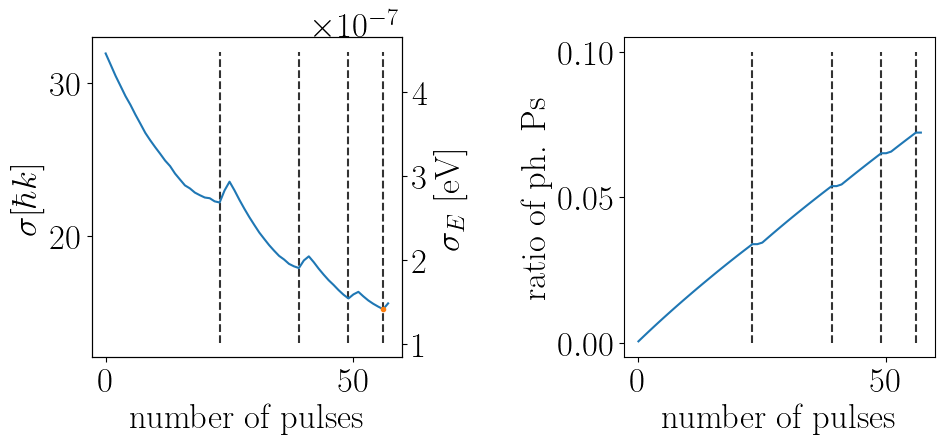

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].vlines([23,39,49,56],13,32,color="black",ls="dashed",alpha=0.8)
axes[0].plot(np.arange(len(sorted_sequence)),stds2)
axes[0].set_xlabel("number of pulses")
axes[0].set_ylabel(r"$\sigma [\hbar k]$")
axes[0].plot(np.argmin(stds2),np.amin(stds2),'.')
print(np.argmin(stds2),np.amin(stds2))
twinax = axes[0].twinx()
twinax.plot(np.arange(len(sorted_sequence)),np.asarray(stds2)**2/(2*system.m/c**2),alpha=0)
twinax.set_ylabel(r"$\sigma_E$ [eV]")

axes[1].vlines([23,39,49,56],0,0.1,color="black",ls="dashed",alpha=0.8)
axes[1].plot(np.arange(len(sorted_sequence)),expect_ph)
axes[1].set_xlabel("number of pulses")
axes[1].set_ylabel("ratio of ph. Ps")
fig.tight_layout()
plt.savefig("./figures/thesis_draft/cooling_broadband_ideal_20ps.svg",bbox_inches="tight")
#print("minimum: {:.2f} after {} pulses".format(np.amin(stds2),np.argmin(stds2)))
#sigma_minimum = np.sqrt(32**2*(1-2/np.pi)+1/4)# expected
#print("expected: {:.2f}".format(sigma_minimum))
plt.show()

In [ ]:
directory = "./data/cooling/ideal_4Trains_23_15_10_8_Pulses_4SE_30ps/"
files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
results = []
saved_states = []
saved_states.append(qt.qload(directory+files_sorted[0]).states[0])
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    results.append(qt.qload(path))
    #saved_states.append(results[i].states[-1])
    #saved_states.append(qt.qload(path).states[-1])

: 

In [ ]:
# saved_states_copy = saved_states.copy()
# O = qt.tensor(qt.qeye(system.N_points),qt.Qobj([[0,1],[0,0]]))
# final_state = saved_states_copy[np.argmin(stds2)+1] # add +1 because the list does not include desymmetrization
# #print(O*states)
# print(np.argmin(stds2)+1)
# print(handler.expect_standard_deviation(O*final_state,system.N_points))
# system.states = O*final_state

# #print(system.states)
# start=False

minimum: 15.08 after 60 pulses
[31.834396257211573, 31.115120701513202, 30.420893299895074, 29.736656748282535, 29.077346650171286, 28.439288527352524, 27.82136621661563, 27.229292658296743, 26.66114874763452, 26.114411880925456, 25.601019642777207, 25.109627841169633, 24.654115948064543, 24.228040203673356, 23.83704659685722, 23.472411981333554, 23.144083567947074, 22.852822499445924, 22.60169544692259, 22.381053740600752, 22.202418160619157, 22.06120846395697, 21.960838575846815, 21.89322851505022, 21.916070386213555, 22.123716312065493, 21.572541514484946, 21.044001219284635, 20.543796288862442, 20.075569464880004, 19.637207046779903, 19.241598384086, 18.876882546101385, 18.555056911760474, 18.268899739763683, 18.028510870992065, 17.830162840255536, 17.68122285380665, 17.5774139545302, 17.525839144532007, 17.5154629137489, 17.53919341321283, 17.674850114704686, 17.306116731129066, 16.9719118147039, 16.67059618474352, 16.41723142527252, 16.209969985344696, 16.042655925787816, 15.9250

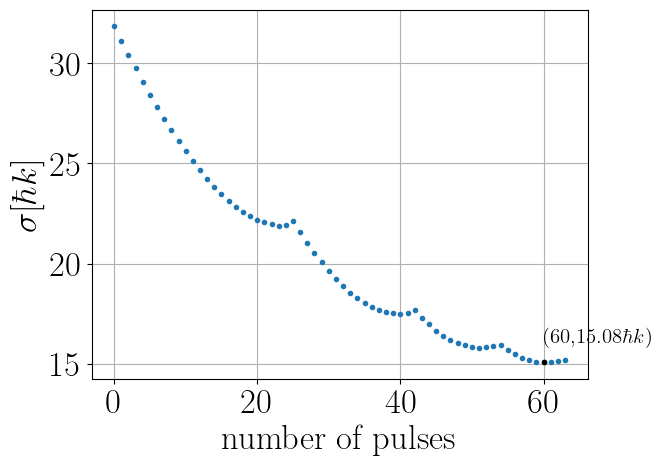

In [ ]:
# same as below but only loads one result at a time to save me from RAM headaches
handler = data_handler()
directory = "./data/cooling/ideal_4Trains_23_15_10_8_Pulses_4SE_30ps_R120GHz_C70GHz/"
files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
stds = []
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    state = result.states[-1]
    stds.append(handler.expect_standard_deviation(state,system.N_points))

# for state in saved_states:
#     stds.append(handler.expect_standard_deviation(state,system.N_points))
plt.plot(np.arange(len(stds)),stds,'.')
plt.ylabel(r"$\sigma [\hbar k]$")
plt.xlabel("number of pulses")
#plt.title("4 Trains, 2 Pulses, 4 SE events")
plt.plot(np.argmin(stds),np.amin(stds),'.',color="black")
print("minimum: {:.2f} after {} pulses".format(np.amin(stds),np.argmin(stds)))
plt.text(np.argmin(stds),np.amin(stds)+1,"({},{:.2f}$\hbar k$)".format(np.argmin(stds),np.amin(stds)),fontsize=15)
plt.grid()
#plt.savefig("./figures/mar_2023/cooling_ideal_Train3.svg",bbox_inches="tight")
print(stds)

minimum: 23.23 after 62 pulses
[31.52644691062401, 31.834396257211573, 31.236094925187224, 30.77272864005124, 30.351736072639692, 29.92727215784658, 29.522716846008244, 29.1434331418313, 28.81077367409438, 28.502149258480244, 28.227428887601302, 28.00658168958288, 27.842905320244785, 27.69711469996618, 27.565657345545734, 27.471049036207763, 27.42215620928021, 27.412599583274105, 27.44239386417673, 27.48721226288377, 27.573594265140333, 27.672272041168625, 27.767275246947104, 27.854643102156064, 27.95833074118146, 28.007672660030433, 28.263260616999045, 27.788360692410404, 27.443170197399827, 27.12173262500083, 26.806921088595914, 26.51473778064827, 26.253789414199083, 26.034729968763788, 25.85594609906248, 25.694249215651638, 25.574300765313122, 25.505172653977716, 25.47059648293046, 25.48018428101955, 25.530966026427656, 25.605666064177324, 25.625576501095672, 25.769177262494754, 25.397940645061365, 25.152132969095245, 24.936754773659626, 24.72980068319465, 24.550542763189164, 24.400

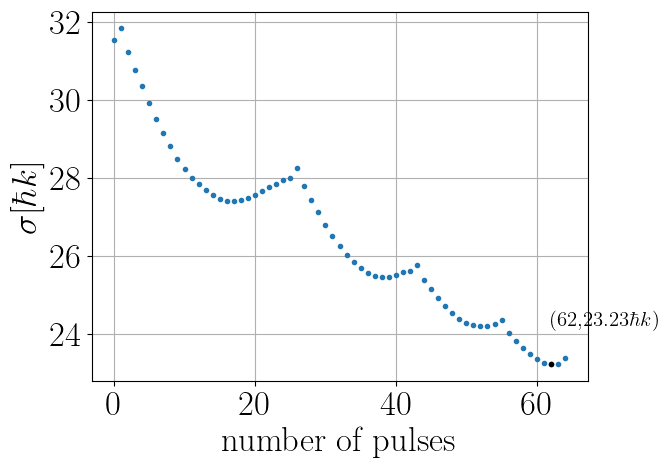

In [ ]:
handler = data_handler()
stds = []
for state in saved_states:
    stds.append(handler.expect_standard_deviation(state,system.N_points))
plt.plot(np.arange(len(stds)),stds,'.')
plt.ylabel(r"$\sigma [\hbar k]$")
plt.xlabel("number of pulses")
#plt.title("4 Trains, 2 Pulses, 4 SE events")
plt.plot(np.argmin(stds),np.amin(stds),'.',color="black")
print("minimum: {:.2f} after {} pulses".format(np.amin(stds),np.argmin(stds)))
plt.text(np.argmin(stds),np.amin(stds)+1,"({},{:.2f}$\hbar k$)".format(np.argmin(stds),np.amin(stds)),fontsize=15)
plt.grid()
#plt.savefig("./figures/mar_2023/cooling_ideal_Train3.svg",bbox_inches="tight")
print(stds)

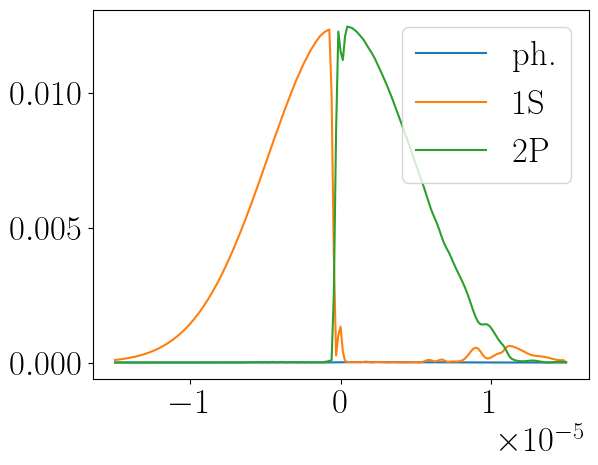

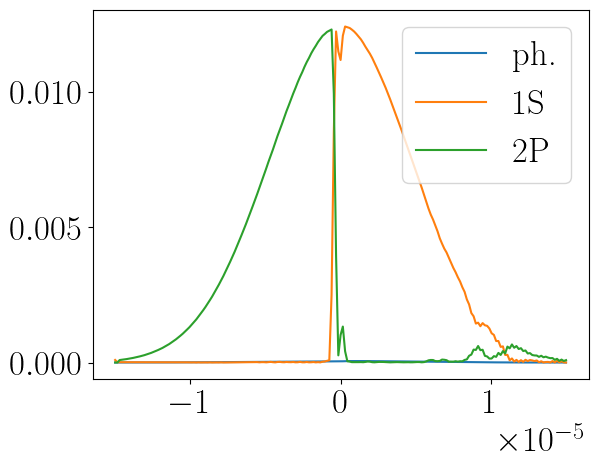

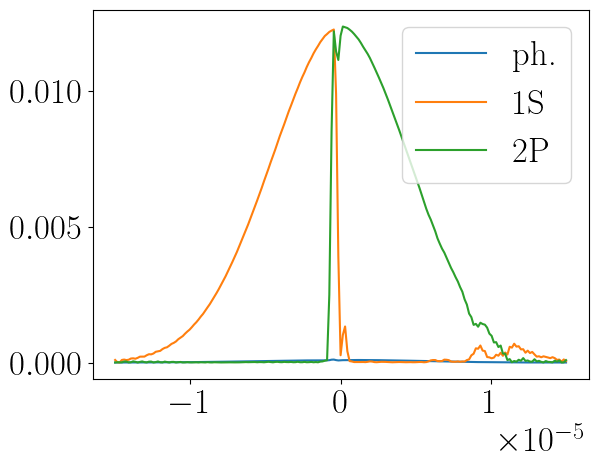

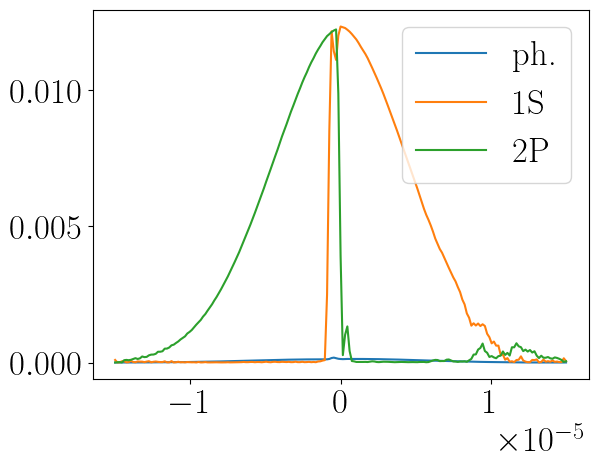

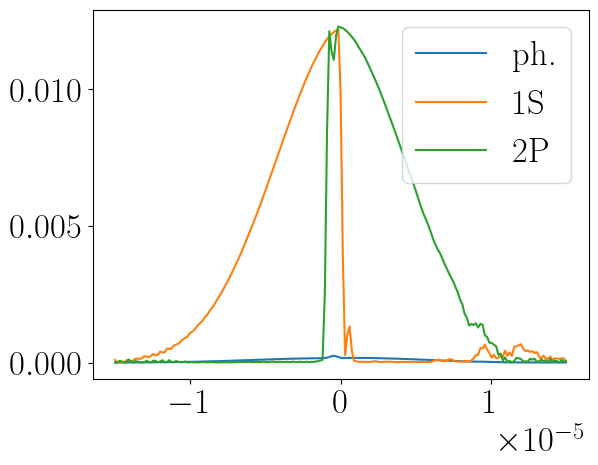

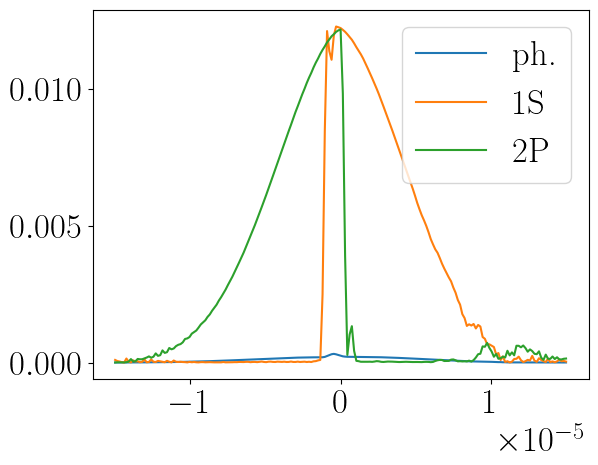

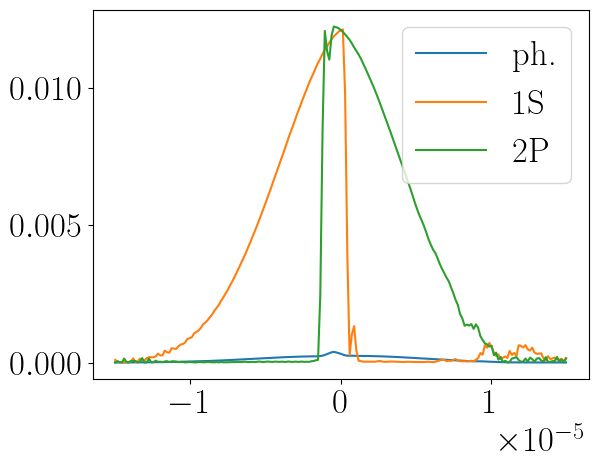

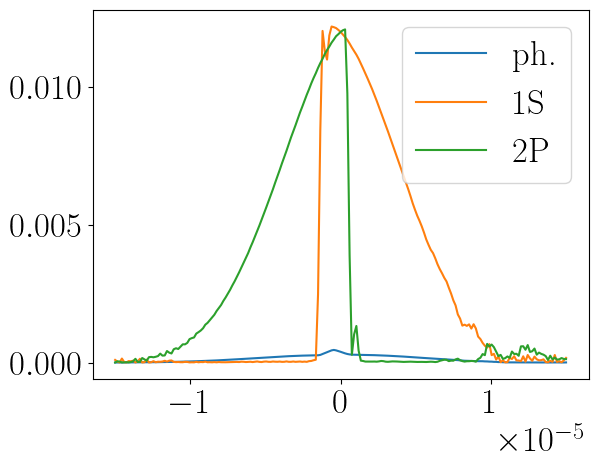

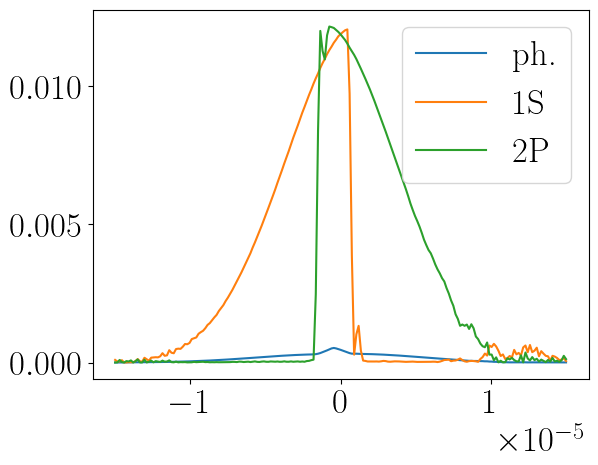

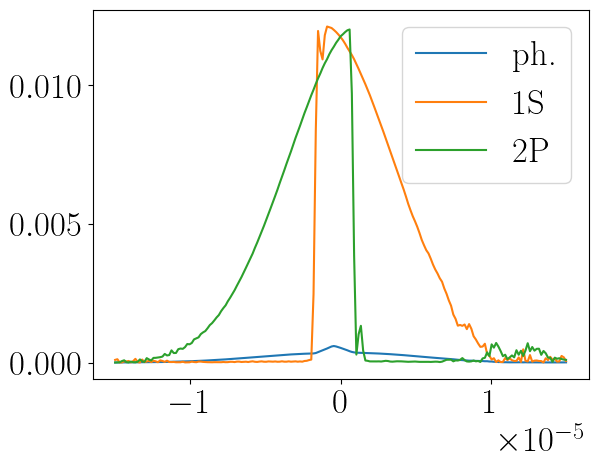

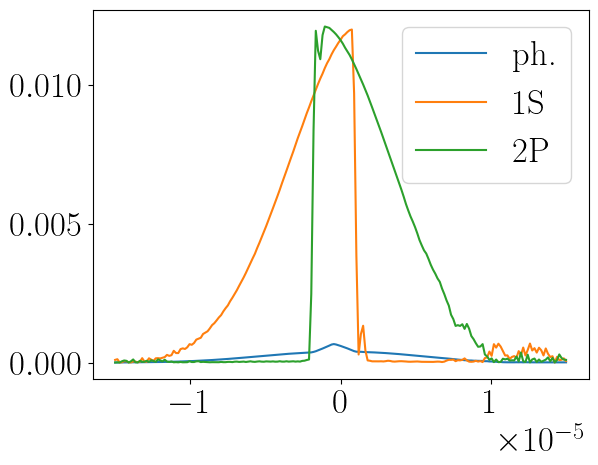

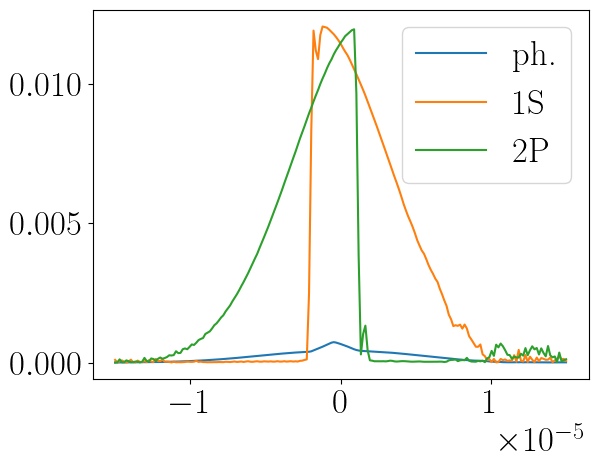

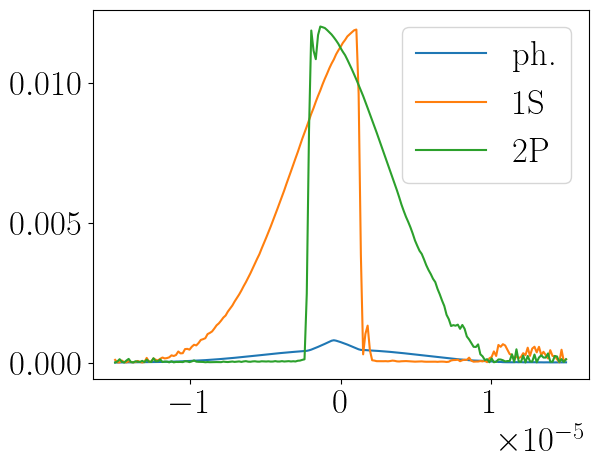

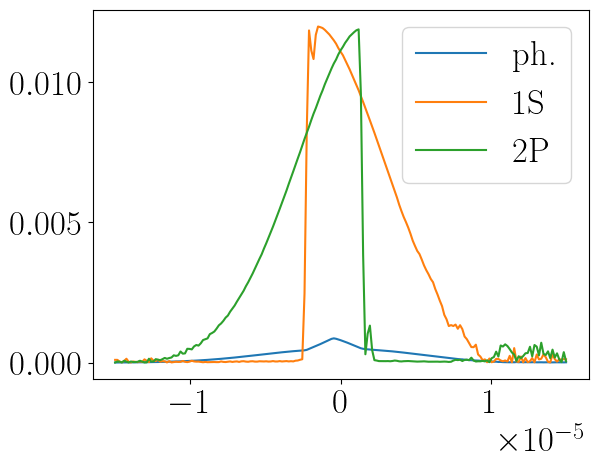

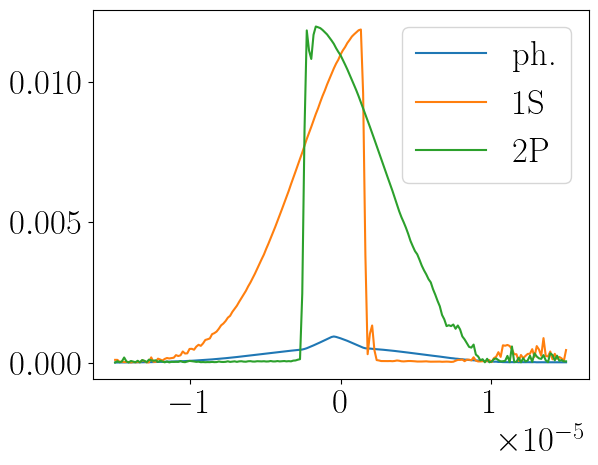

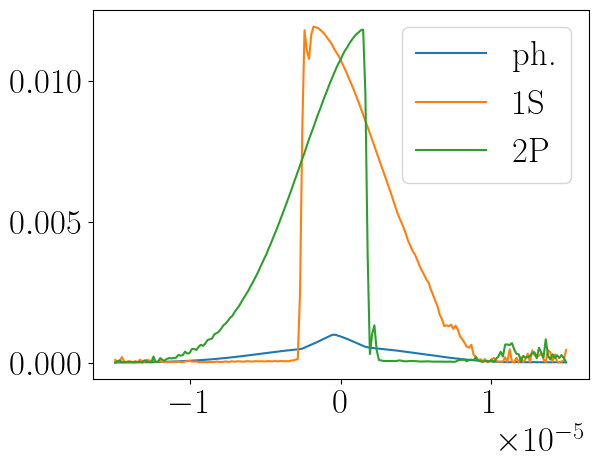

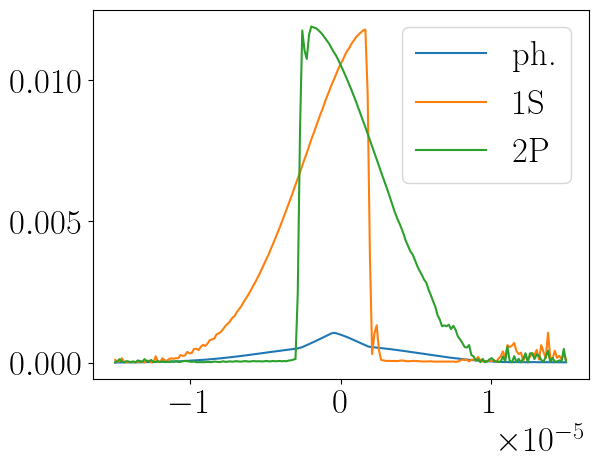

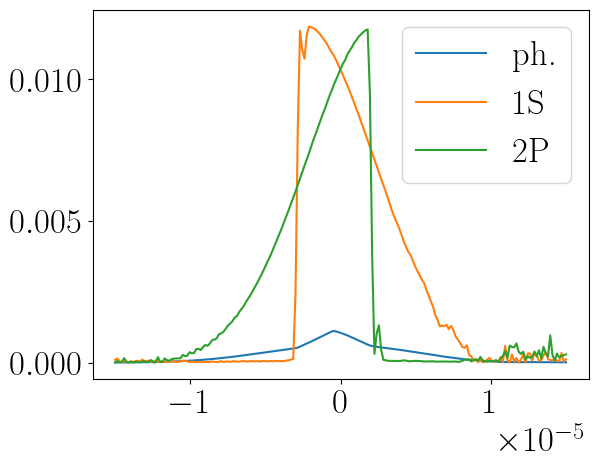

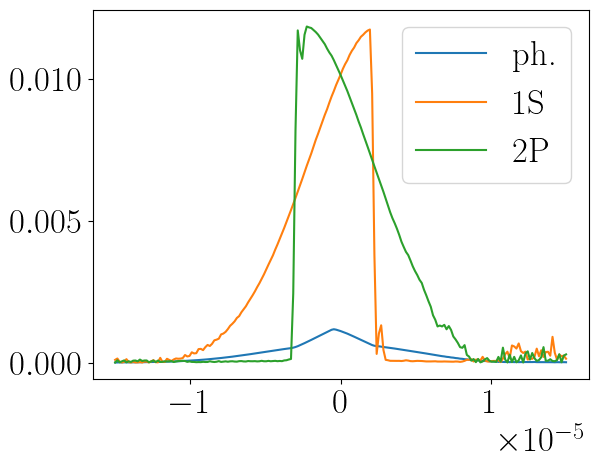

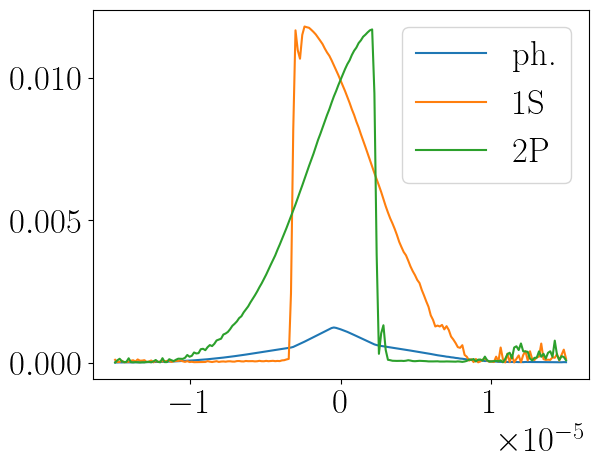

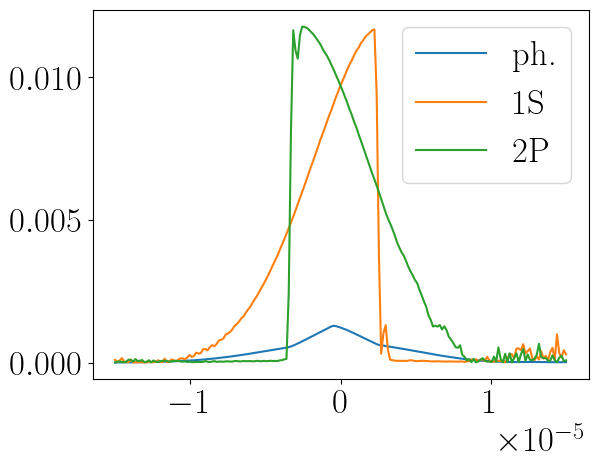

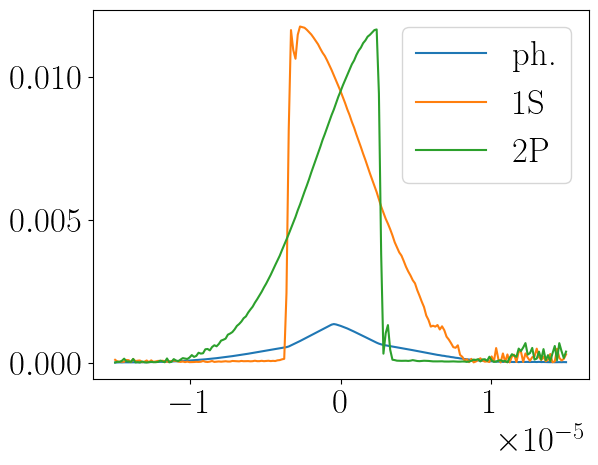

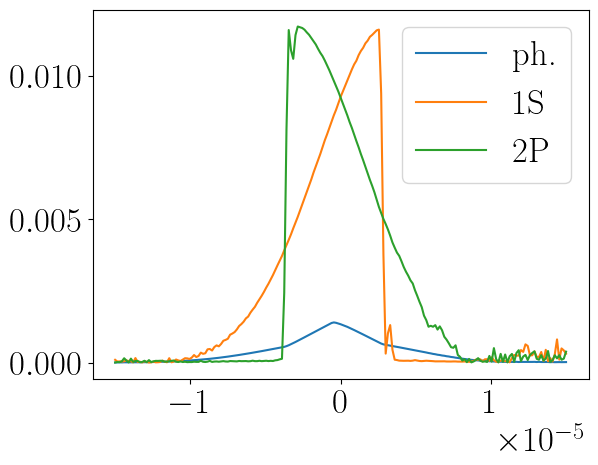

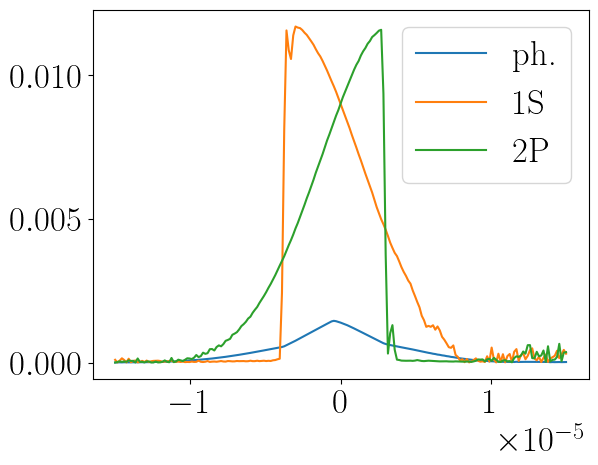

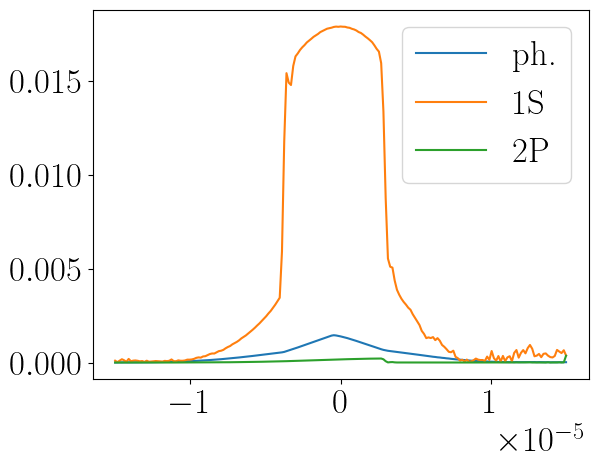

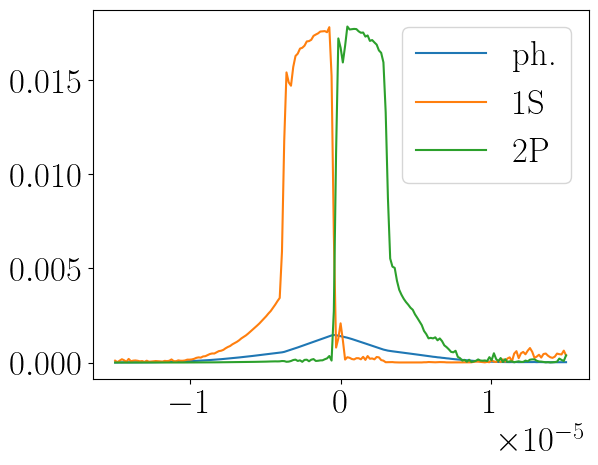

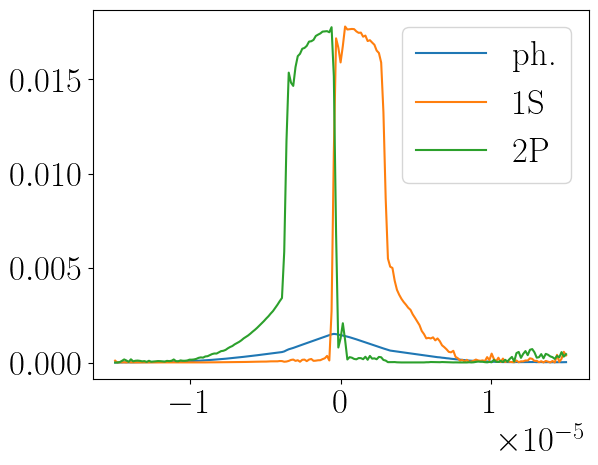

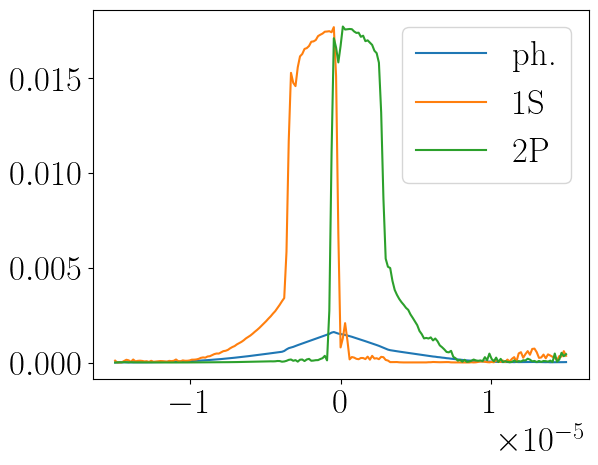

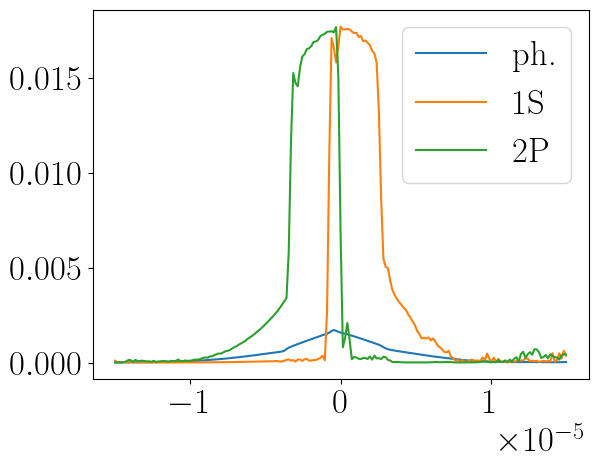

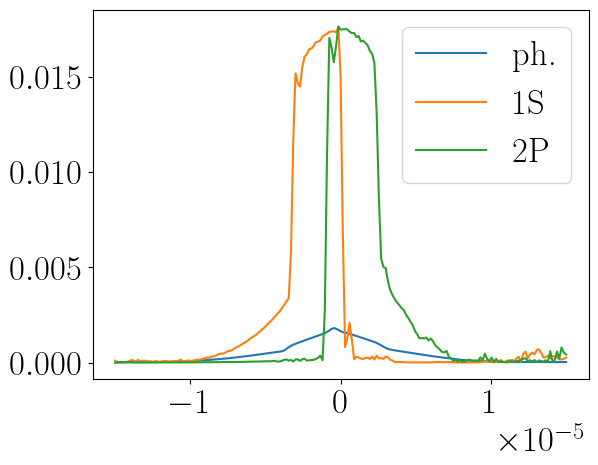

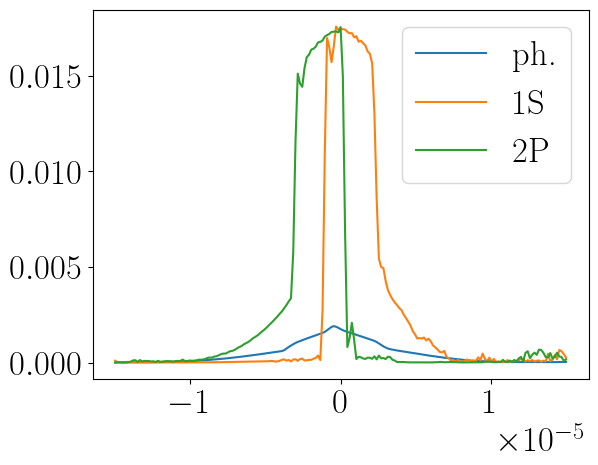

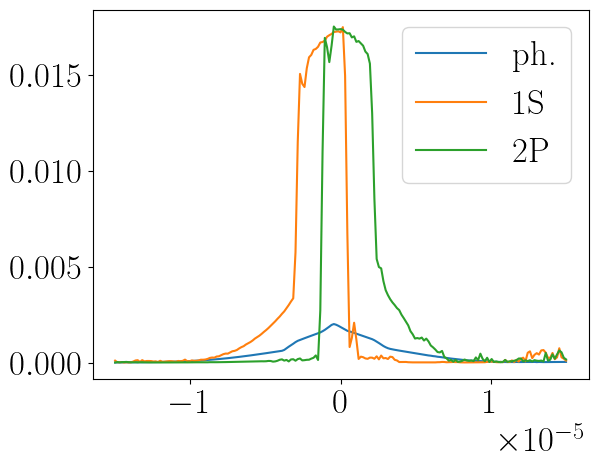

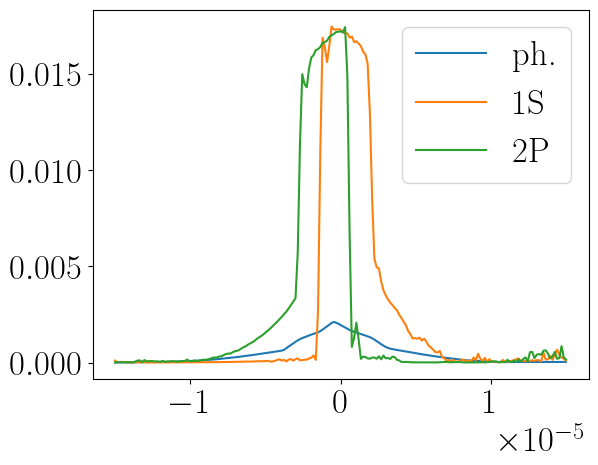

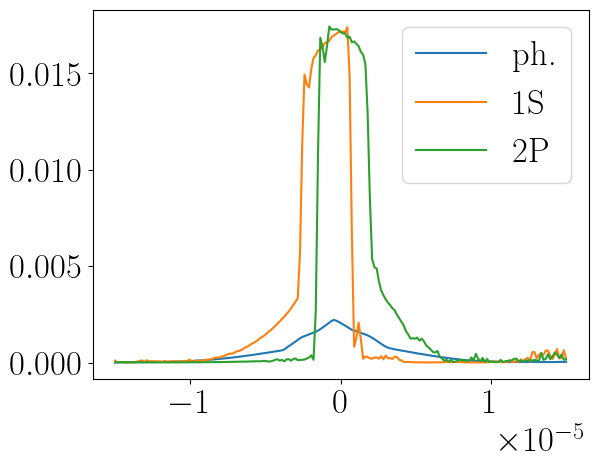

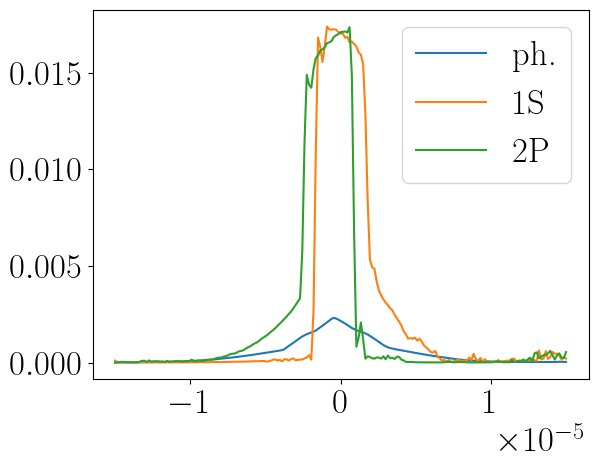

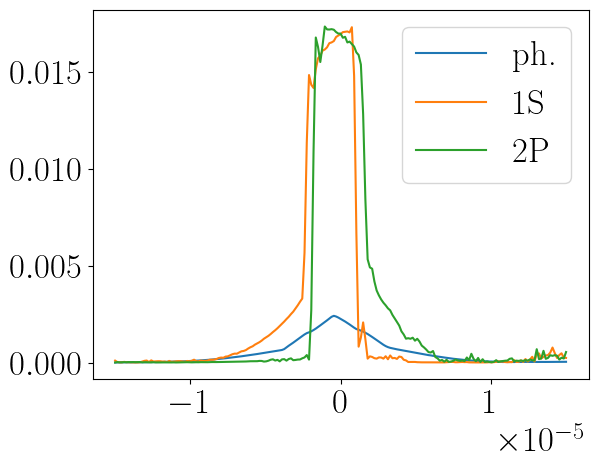

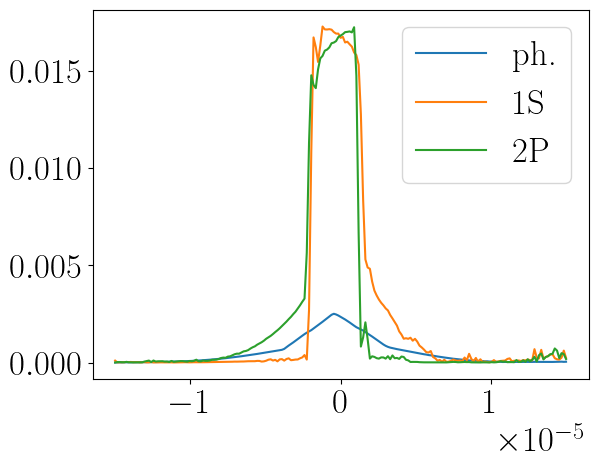

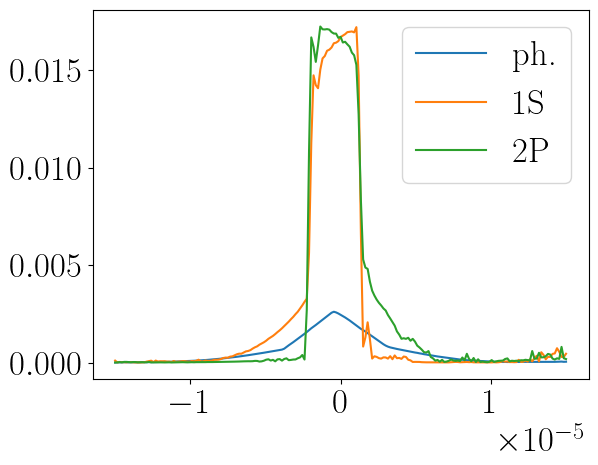

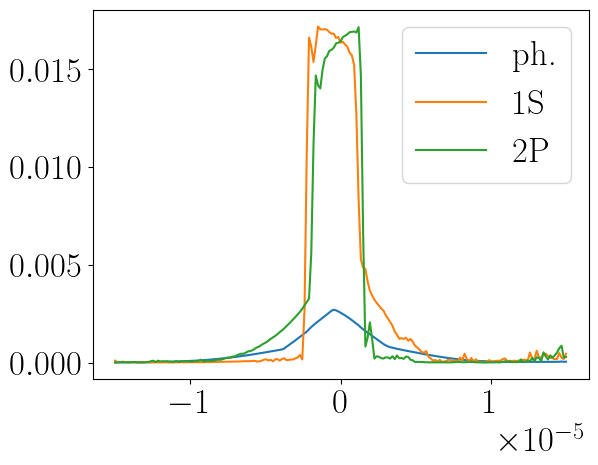

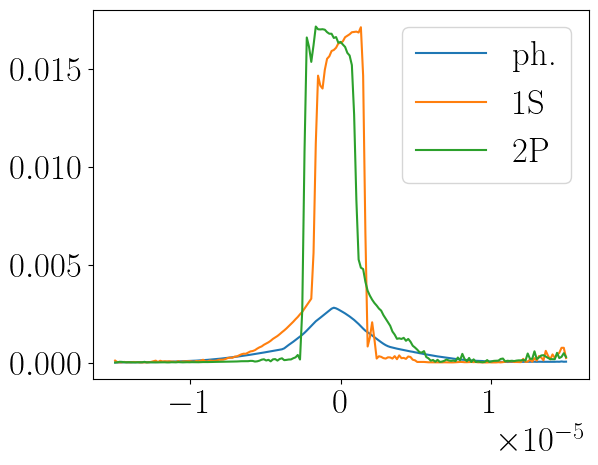

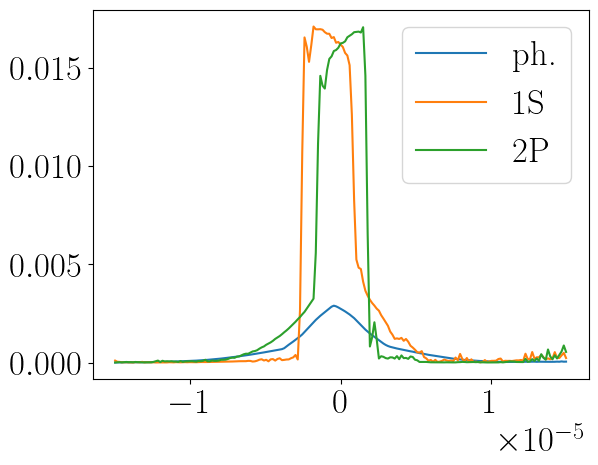

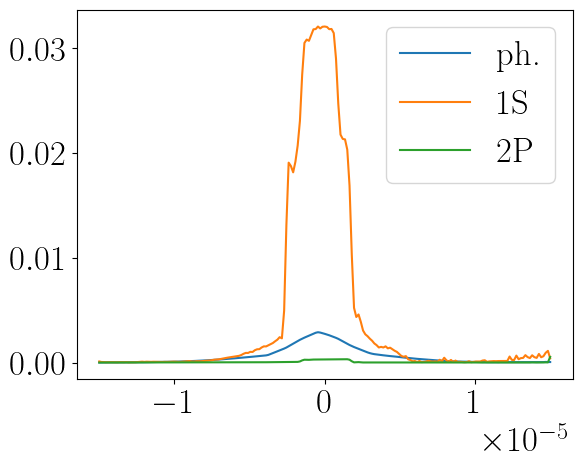

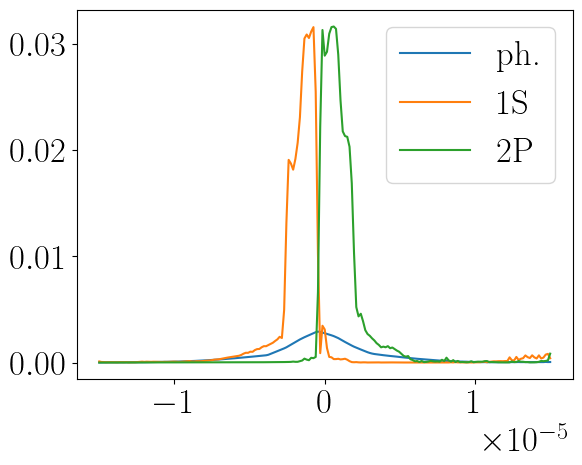

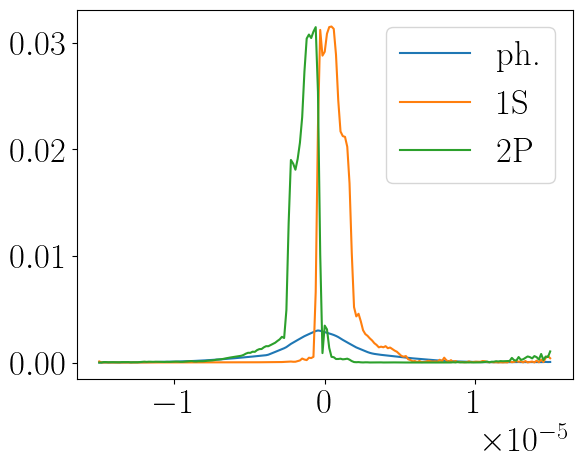

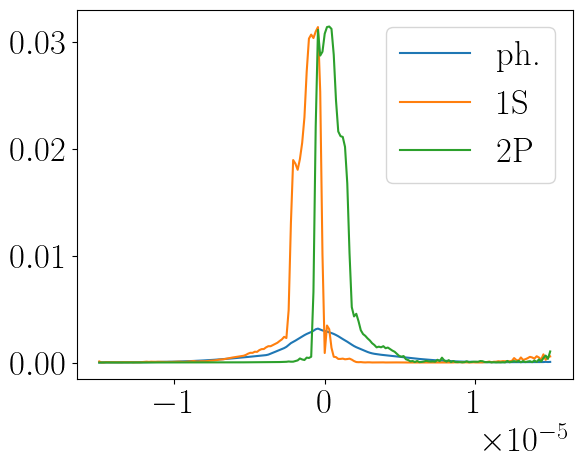

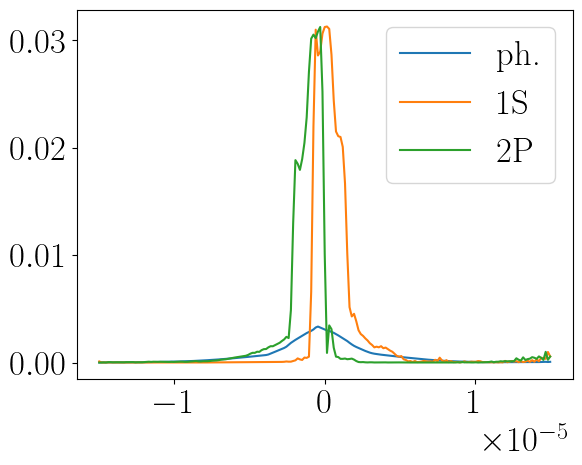

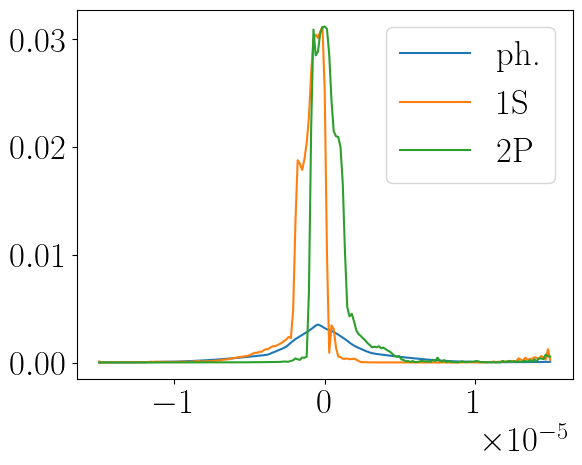

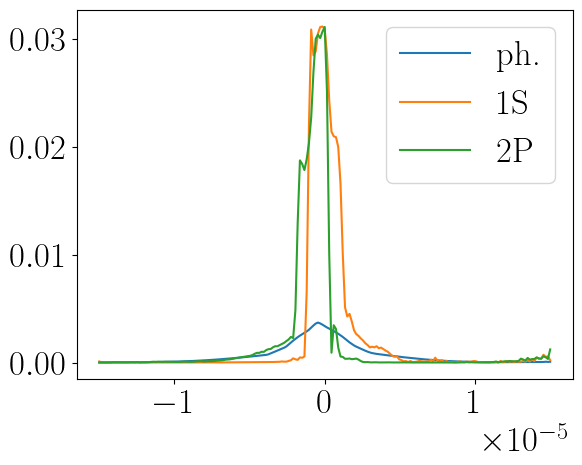

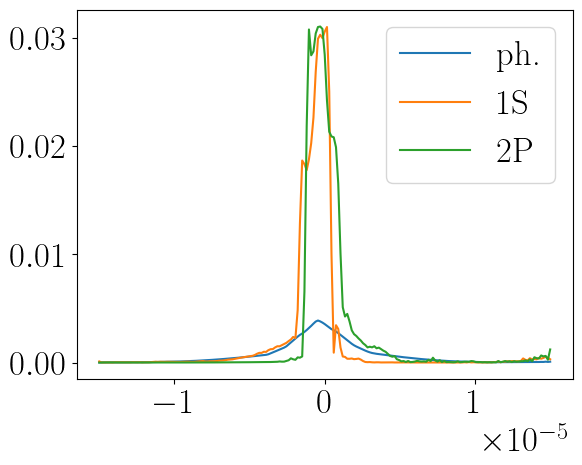

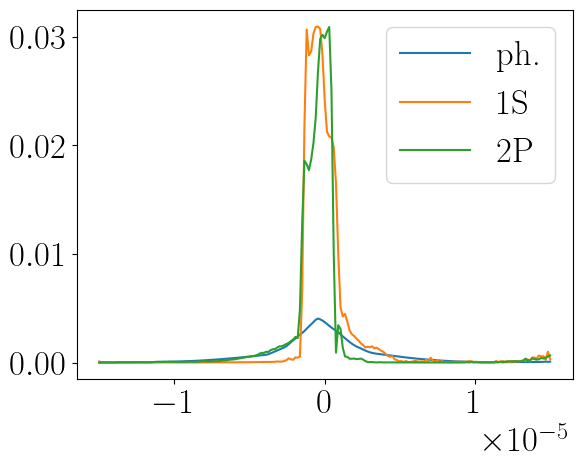

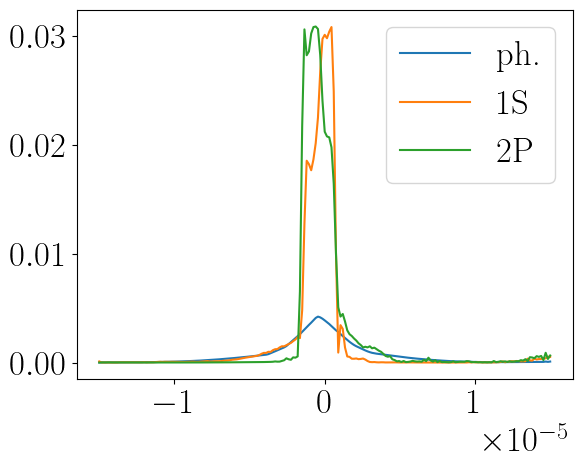

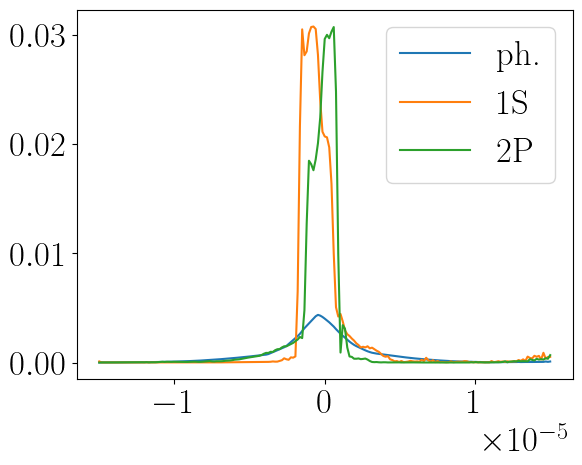

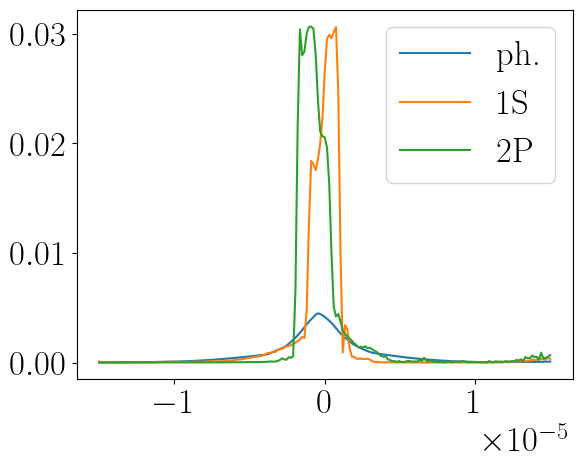

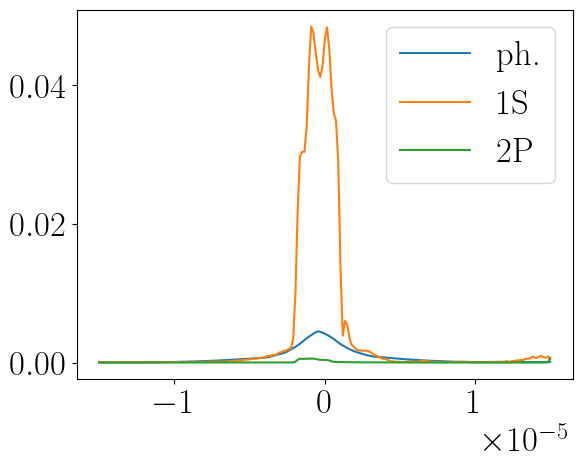

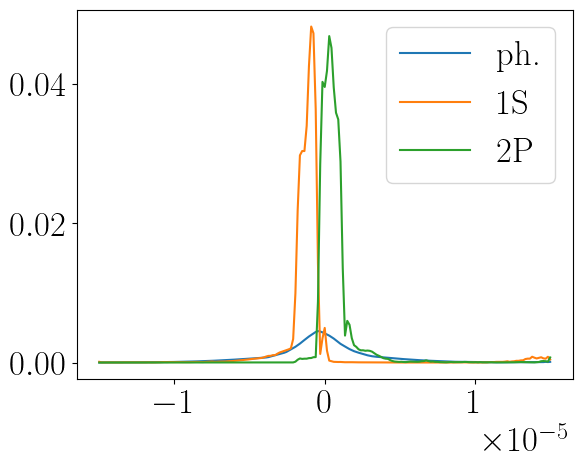

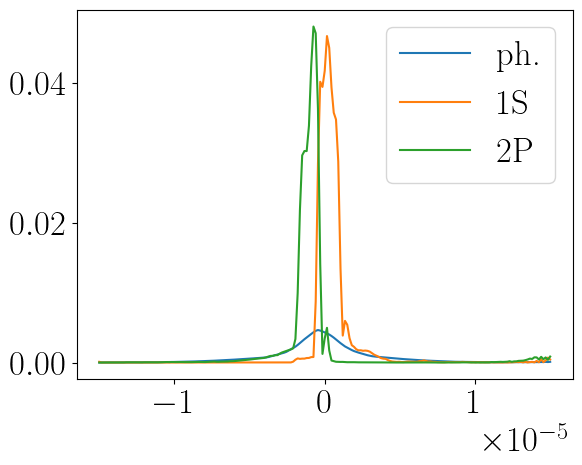

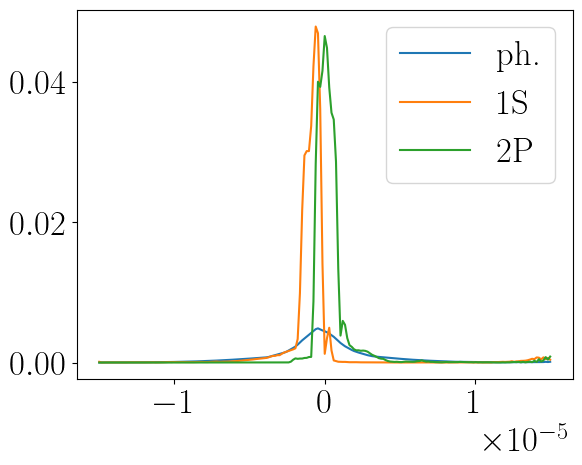

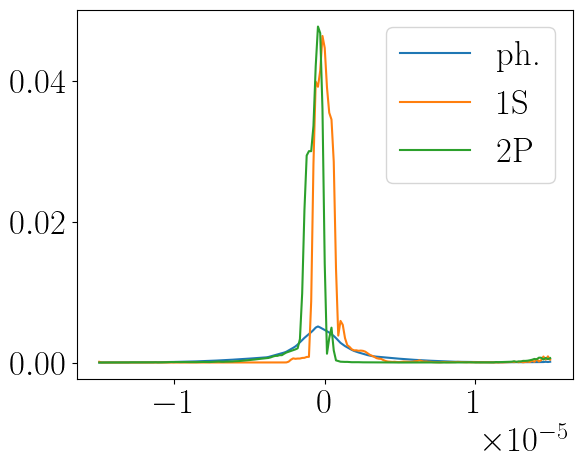

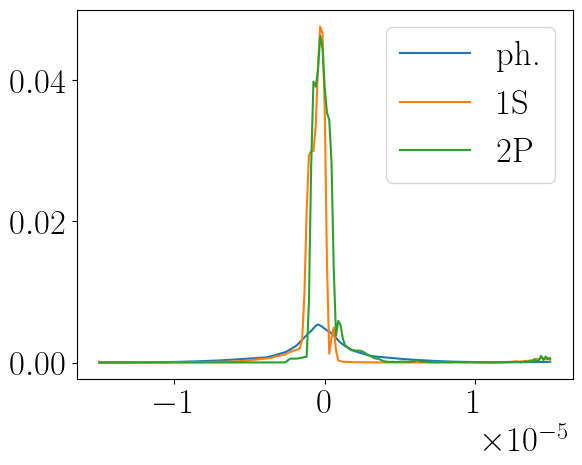

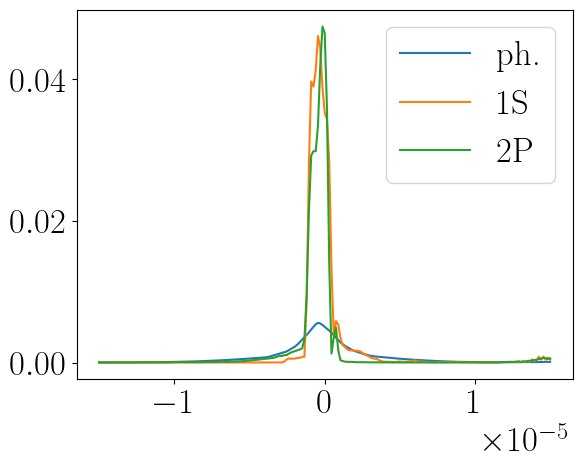

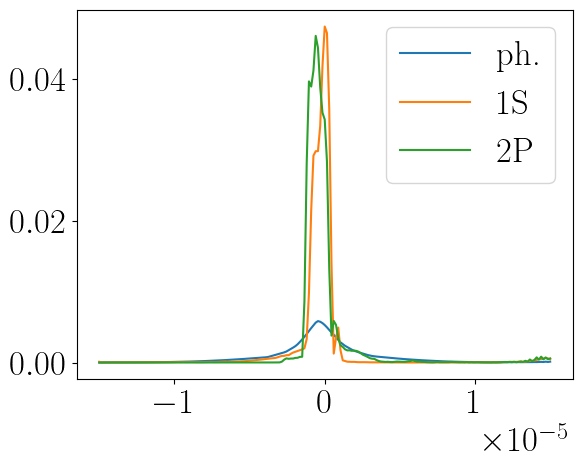

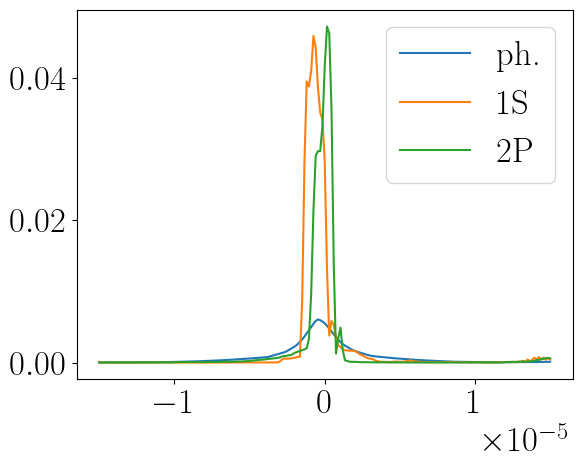

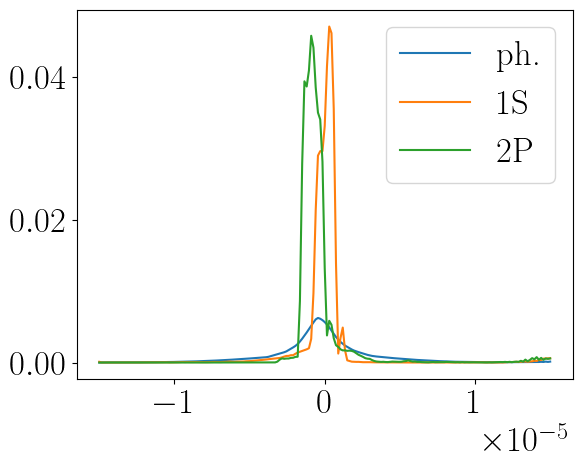

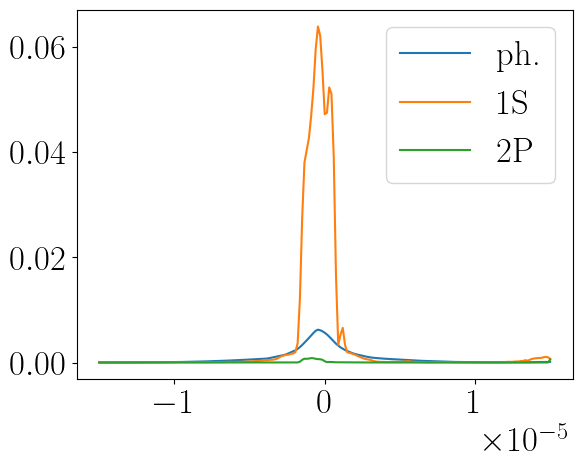

In [ ]:
laser = sequence.laserDict["desymmetrization0"]
system.create_composite(laser)
handler = data_handler()
directory = "./data/cooling/ideal_4Trains_23_15_10_8_Pulses_4SE_30ps_R120GHz_C70GHz/"
files = os.listdir(directory)
files_sorted = sorted(files,key=lambda x:int(x.split("_")[0]))
stds = []
for i in range(len(files_sorted)):
    file = files_sorted[i]
    path = directory+file
    result = qt.qload(path)
    system.organise_result(result)
    fig,ax = plt.subplots()
    for key in system.expect:
        #if key == "ph.":
        ax.plot(system.velocity_bins,system.expect[key][-1],label=key)
    plt.legend()
    plt.show()